# DELE ST1504 CA2
# PART A: GAN

<hr>

**NAME**: Irman Zafyree, Adam Tan

**ADMIN NO**: `2300546`, `2300575`

**CLASS**: DAAA/FT/2B/07

<hr>

**Objective:**

Code a GAN model that is able to generate 260 small black-and-white images of the given dataset in 26 distinct classes.

**Background:**
A Generative Adversarial Network (GAN) is a type of deep learning model consisting of two neural networks: a generator and a discriminator. The primary purpose of a GAN is to generate new data instances that resemble the training data, through a competitive process between a generator and a discriminator. It has revolutionized the field of generative modeling and continues to be a vibrant area of research and application in artificial intelligence.





# Initial Set Up

In [30]:
# Basic imports
from dotenv import load_dotenv
import os

os.environ['TF_CPP_MIN_VLOG_LEVEL'] = '3'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["KERAS_BACKEND"] = "tensorflow"

import pandas as pd
import numpy as np
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from scipy.linalg import sqrtm
from numpy.random import randn, randint,random
import matplotlib.pyplot as plt
import tensorflow as tf
#print(tf.__version__)
from tqdm import tqdm
from IPython import display
import warnings

# Tensorflow imports
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.metrics import Mean
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import Dense, Reshape, Conv2D, LeakyReLU, Dropout, Flatten, Conv2DTranspose, BatchNormalization, Input, Embedding, Concatenate, Lambda, MaxPooling2D, UpSampling2D, Activation, GlobalAveragePooling2D, AveragePooling2D, GlobalMaxPooling2D, Multiply, ZeroPadding2D
from tensorflow.train import Checkpoint
from tensorflow.keras.utils import to_categorical


# Sklearn imports
from sklearn.model_selection import train_test_split

# Keras
import keras
from keras import backend as K
from keras import metrics
from keras import layers

# Keras_tuner
import keras_tuner as kt

warnings.filterwarnings("ignore")

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

load_dotenv()

dataset_path = os.environ.get("DATASET_PATH")

print(dataset_path)


emnist-letters-train.csv


In [31]:

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print(tf.config.experimental.get_device_details(gpu))
    tf.config.experimental.set_memory_growth(gpu, True)
print(f"There are {len(gpus)} GPUs")

{'device_name': 'NVIDIA GeForce RTX 3070 Laptop GPU', 'compute_capability': (8, 6)}
There are 1 GPUs


In [32]:
df = pd.read_csv(dataset_path, header=None)
df

0    1    2    3    4    5    6    7    8    9    ...  775  776  777  \
0       23    0    0    0    0    0    0    0    0    0  ...    0    0    0   
1        7    0    0    0    0    0    0    0    0    0  ...    0    0    0   
2       16    0    0    0    0    0    0    0    0    0  ...    0    0    0   
3       15    0    0    0    0    0    0    0    0    0  ...    0    0    0   
4       23    0    0    0    0    0    0    0    0    0  ...    0    0    0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
99035   18    0    0    0    0    0    0    0    0    0  ...    0    0    0   
99036   24    0    0    0    0    0    0    0    0    0  ...    0    0    0   
99037   19    0    0    0    0    0    0    0    0    0  ...    0    0    0   
99038   -1  174  174  174  174  174  174  174  174  174  ...  174  174  174   
99039   -1   42   42   42   42   42   42   42   42   42  ...   42   42   42   

       778  779  780  781  782  783  784  
0        0    0    0    0    0    0    0  
1        0    0    0    0    0    0    0  
2        0    0    0    0    0    0    0  
3        0    0    0    0    0    0    0  
4        0    0    0    0    0    0    0  
...    ...  ...  ...  ...  ...  ...  ...  
99035    0    0    0    0    0    0    0  
99036    0    0    0    0    0    0    0  
99037    0    0    0    0    0    0    0  
99038  174  174  174  174  174  174  174  
99039   42   42   42   42   42   42   42  

[99040 rows x 785 columns]

In [33]:
df.isnull().sum()

0      0
1      0
2      0
3      0
4      0
      ..
780    0
781    0
782    0
783    0
784    0
Length: 785, dtype: int64

Background Research

**CSV Dataset:**
- the datatset consists of 99040 datasets
- the first column represents the classs labels -1 to 26.
- Remaining 784 columns are the pixel data

**Classes:**

Total of 27 distinct classes 
1. -1 (all black)
2. 1 (a)
3. 2 (b)
4. 3 (c)
5. 4 (d)
6. 5 (e)
7. 6 (f)
8. 7 (g)
9. 8 (h)
10. 9 (i)
11. 10 (j)
12. 11 (k)
13. 12 (l)
14. 13 (m)
15. 14 (n)
16. 15 (o)
17. 16 (p)
18. 17 (q)
19. 18 (r)
20. 19 (s)
21. 20 (t)
22. 21 (u)
23. 22 (v)
24. 23 (w)
25. 24 (x)
26. 25 (y)
27. 26 (z)


**Images:**

The images are of size 28x28

In [34]:
labels = df[0]

In [35]:
data = df.drop(df.columns[0], axis=1)
data.head()

1    2    3    4    5    6    7    8    9    10   ...  775  776  777  778  \
0    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
1    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
2    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
3    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
4    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   

   779  780  781  782  783  784  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 784 columns]

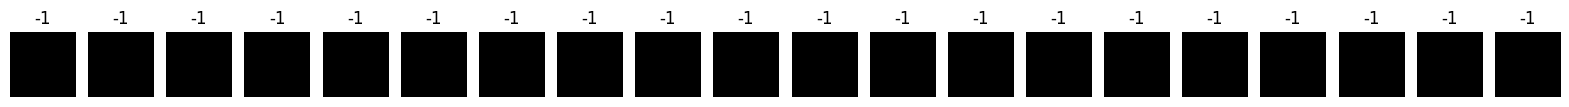

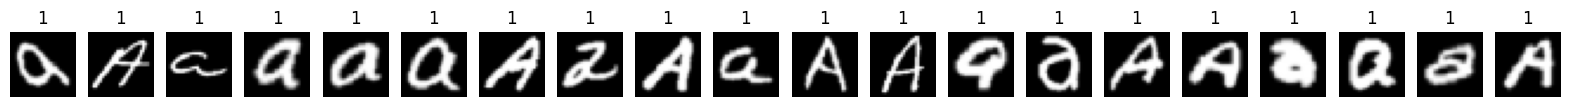

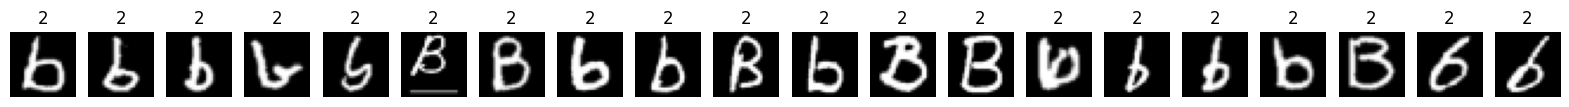

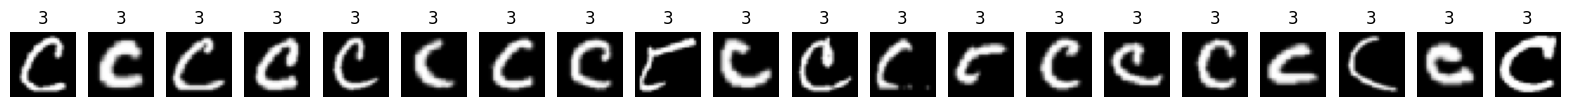

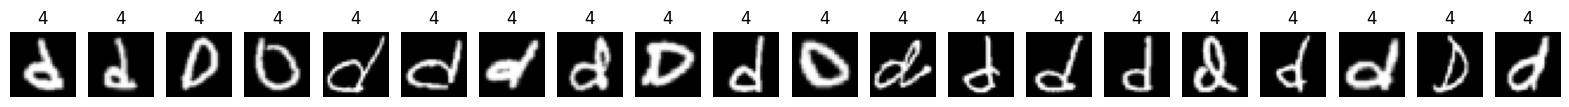

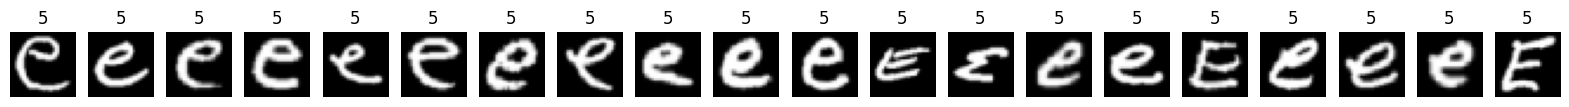

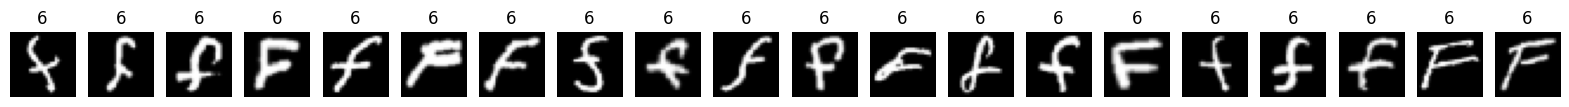

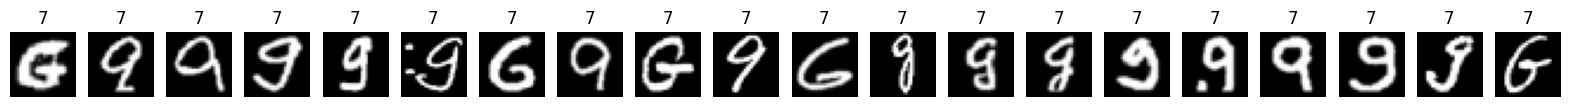

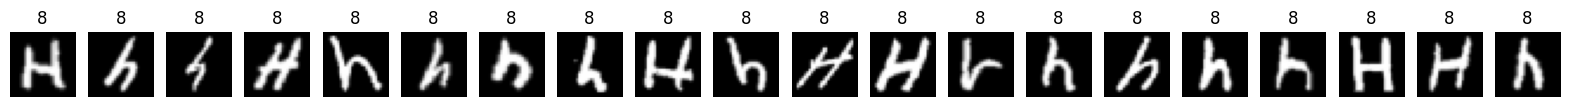

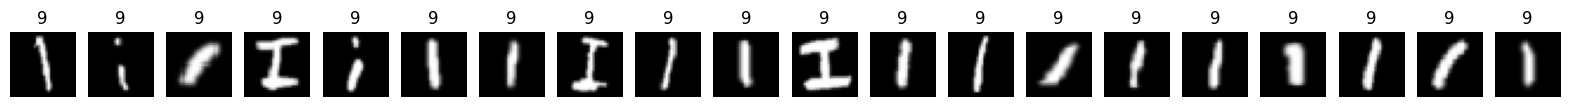

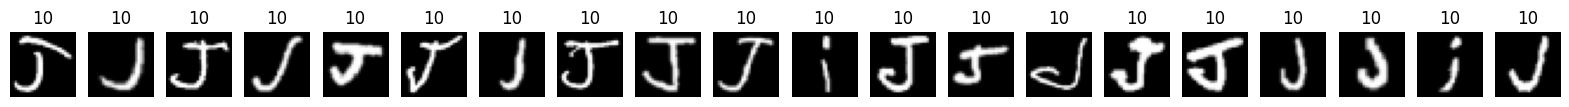

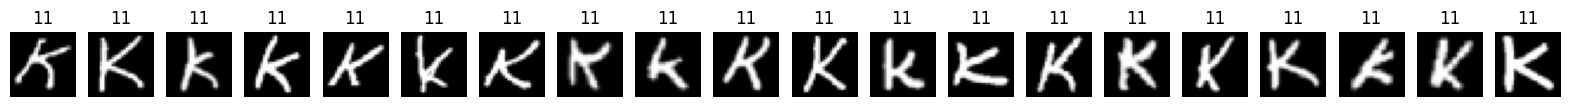

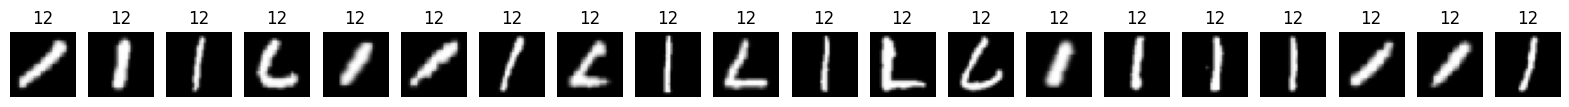

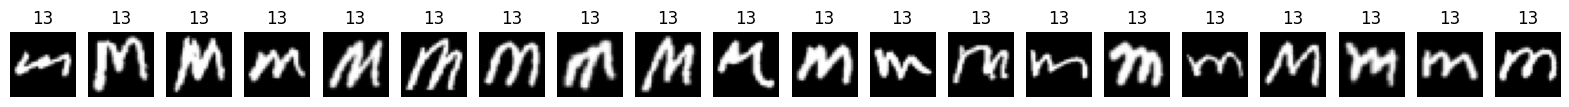

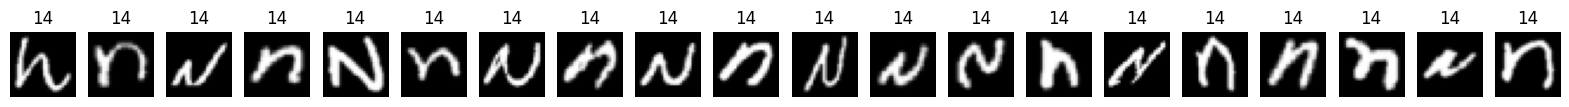

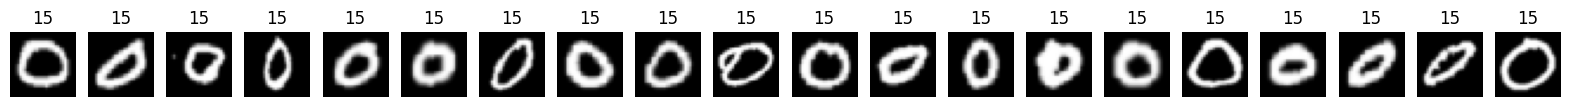

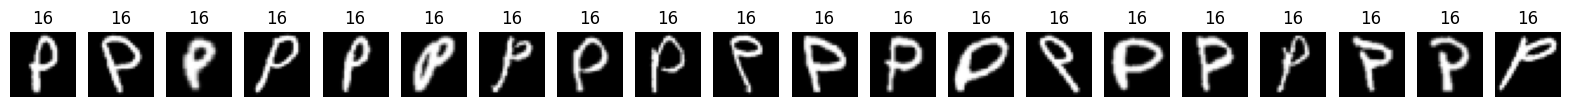

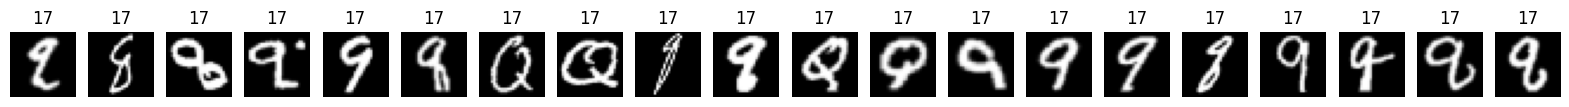

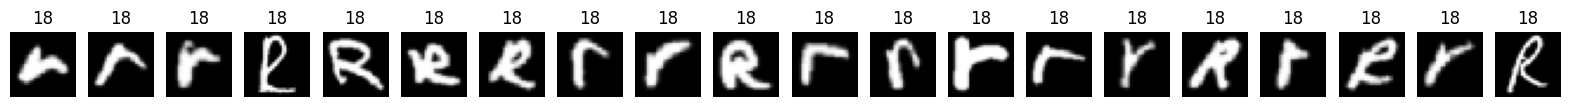

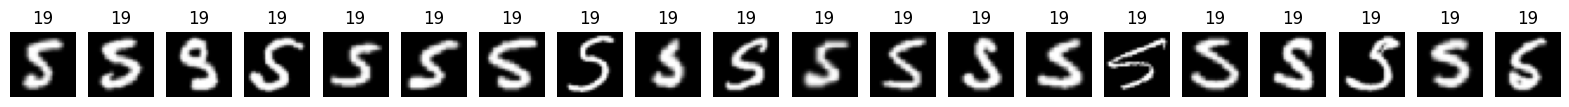

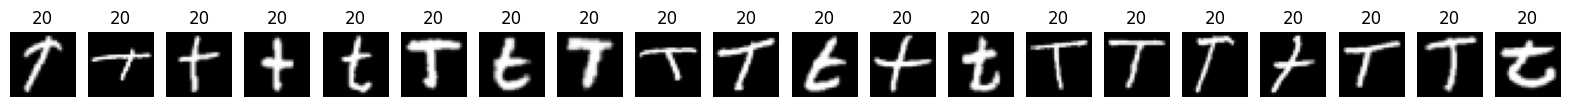

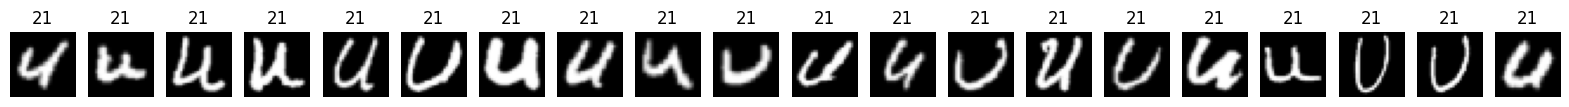

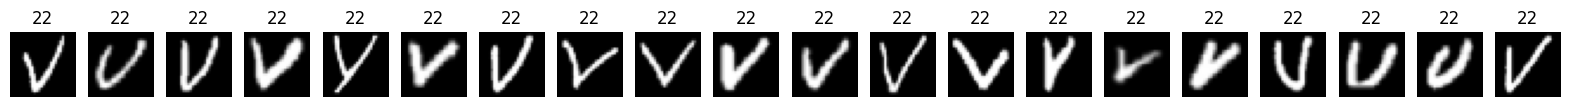

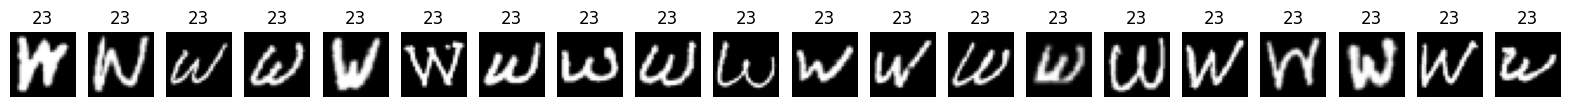

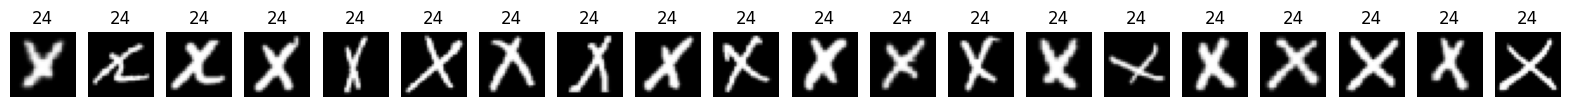

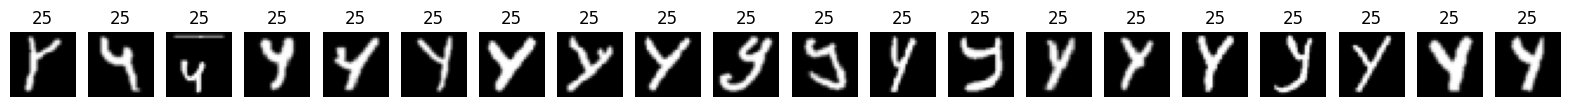

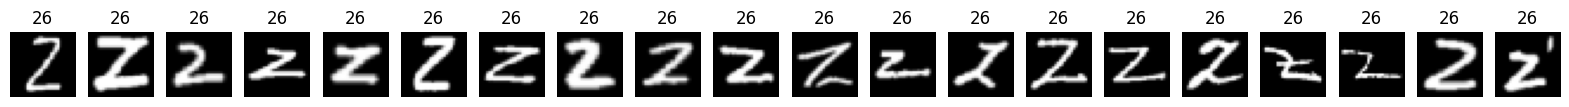

In [36]:

# Function to display images
def display_images(images, label):
    plt.figure(figsize=(20, 4))
    for index, image in enumerate(images[:20]):
        plt.subplot(1, 20, index + 1)
        image = np.array(image).reshape(28, 28)
        rotated_image = np.rot90(image, k=-1)  
        flipped_horizontal = np.fliplr(rotated_image)
        plt.imshow(flipped_horizontal, cmap='gray')
        plt.axis('off')
        plt.title(f"{label}")

# Order labels from -1 to 26
ordered_labels = sorted(labels.unique(), key=lambda x: (x != -1, x))

# Iterate through each ordered label and display 10 images
for label in ordered_labels:
    label_images = data[labels == label].values
    display_images(label_images, label)
    plt.show()

Class distribution:
Label -1: 10240 instances
Label 1: 3396 instances
Label 2: 3396 instances
Label 3: 3419 instances
Label 4: 3398 instances
Label 5: 3437 instances
Label 6: 3394 instances
Label 7: 3385 instances
Label 8: 3424 instances
Label 9: 3428 instances
Label 10: 3402 instances
Label 11: 3438 instances
Label 12: 3415 instances
Label 13: 3402 instances
Label 14: 3365 instances
Label 15: 3408 instances
Label 16: 3430 instances
Label 17: 3435 instances
Label 18: 3419 instances
Label 19: 3392 instances
Label 20: 3436 instances
Label 21: 3419 instances
Label 22: 3422 instances
Label 23: 3423 instances
Label 24: 3437 instances
Label 25: 3453 instances
Label 26: 3427 instances


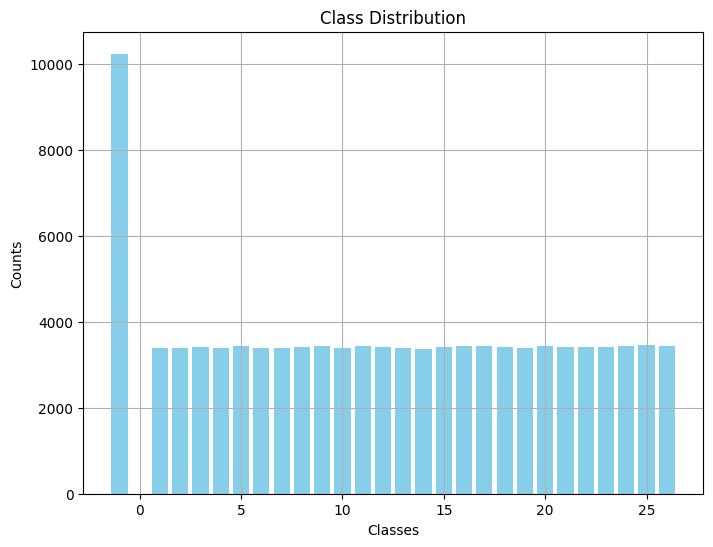

In [37]:
import numpy as np

# Count occurrences of each label
unique_labels, label_counts = np.unique(labels, return_counts=True)

# Print the distribution
print("Class distribution:")
for label, count in zip(unique_labels, label_counts):
    print(f"Label {label}: {count} instances")

plt.figure(figsize=(8, 6))  # Specify the figure size (optional)
plt.bar(unique_labels, label_counts, color='skyblue')

# Customize the chart
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.grid(True)  # Add gridlines for better readability (optional)

# Display the chart
plt.show()

In [38]:
df = df[df[0] != -1]
df.reset_index(inplace=True)

In [39]:
df_labels = df[0]
df_data = df.drop(df.columns[0:2], axis=1)
df_data.head()

1    2    3    4    5    6    7    8    9    10   ...  775  776  777  778  \
0    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
1    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
2    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
3    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
4    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   

   779  780  781  782  783  784  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 784 columns]

In [40]:
augmented_data = df_data.copy()
for i in augmented_data.index:
    pixels = augmented_data.loc[i].values
    image = np.array(pixels).reshape(28, 28)
    rotated_image = np.rot90(image, k=-1)  
    flipped_horizontal = np.fliplr(rotated_image)
    augmented_data.loc[i] = flipped_horizontal.flatten()

In [41]:
print(augmented_data)

       1    2    3    4    5    6    7    8    9    10   ...  775  776  777  \
0        0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
1        0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
2        0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
3        0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
4        0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
88795    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
88796    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
88797    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
88798    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
88799    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   

       778  779  780  781  782  783  784  
0       

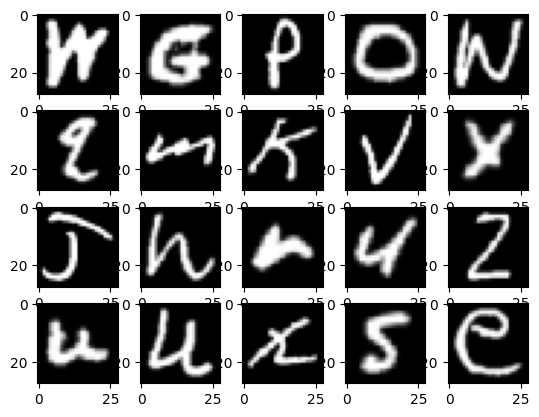

In [42]:
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(np.array(augmented_data.loc[i]).reshape(28, 28), cmap='gray')

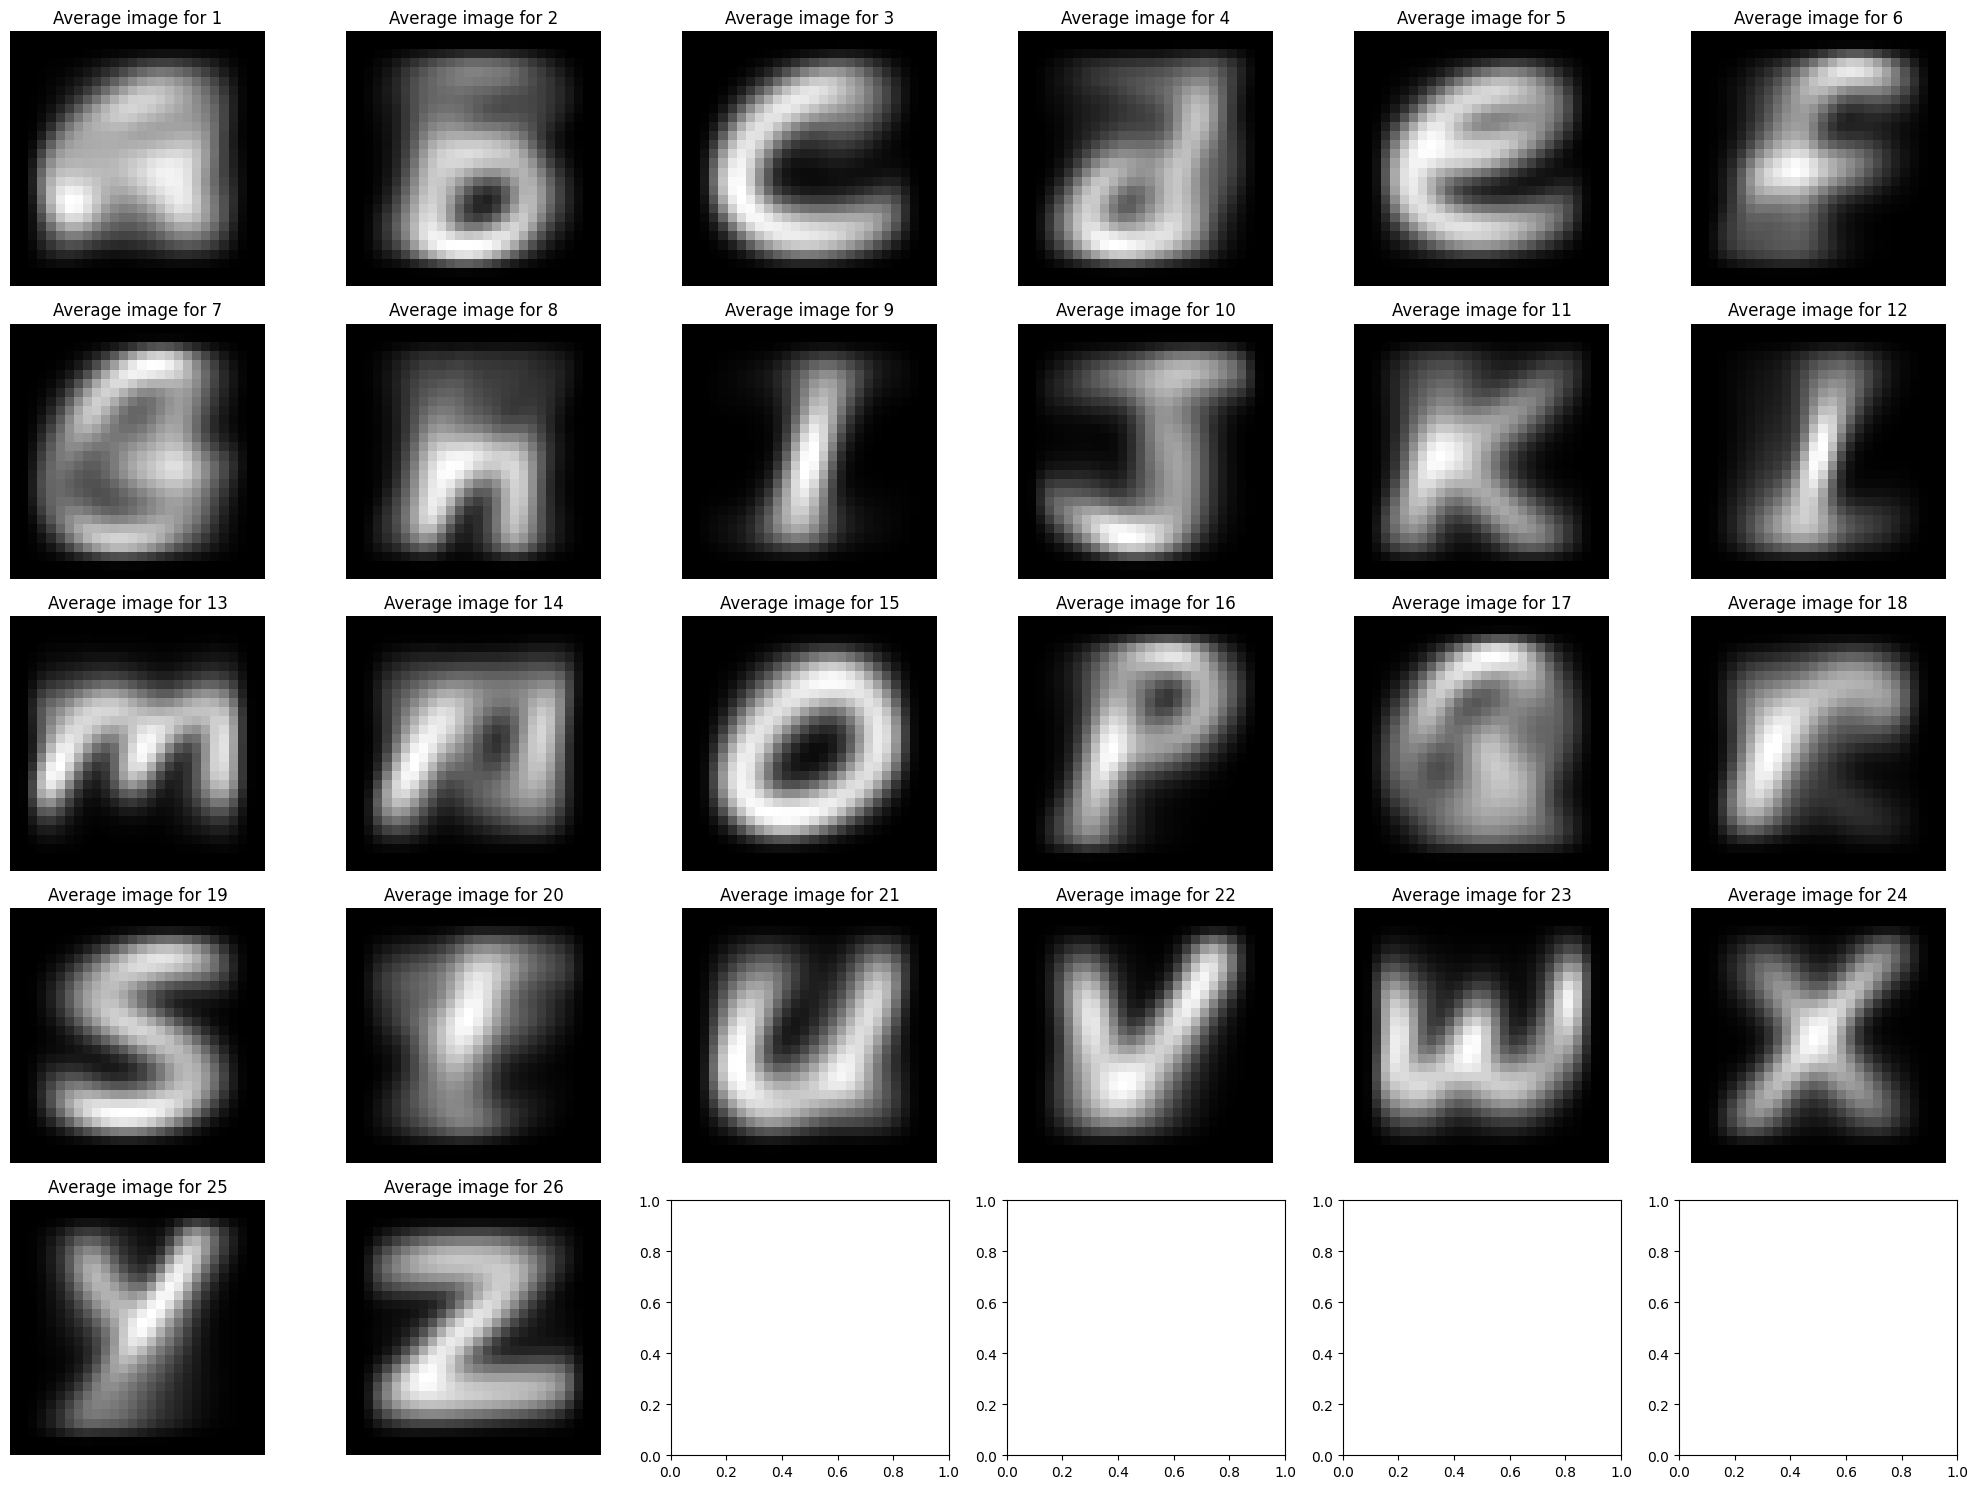

In [43]:
def average_images_per_class(data, labels):

    avg_image_df = pd.DataFrame()

    # average image
    for class_name, group in data.groupby(labels):
        avg_image = group.mean()
        avg_image_df[class_name] = avg_image

    # Create a col of subplots
    fig, axes = plt.subplots(5, 6, figsize=(20, 15))
    for ax, (class_name, avg_image) in zip(axes.flatten(), avg_image_df.items()):
        # image = avg_image.reshape(28, 28)
        # rotated_image = np.rot90(image, k=-1)  
        # flipped_horizontal = np.fliplr(rotated_image)
        # ax.imshow(flipped_horizontal, cmap='gray')
        # ax.set_title(f"Average image for {class_name}")
        # ax.axis('off')  # Turn off axis

        ax.imshow(np.array(avg_image).reshape(28, 28), cmap='gray')
        ax.set_title(f"Average image for {class_name}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

average_images_per_class(augmented_data, df_labels)


# Model Research

From researching online, there seem to be 3 GAN Variations, Deep Convolutional GAN (DCGAN), Conditional GAN (CGAN), Wasserstein GAN (WGAN).

### Deep Convolutional GAN (DCGAN)

DCGANs use deep convolutional neural networks to learn the features of the input data, which allows them to generate high-resolution images that are similar to the training data. The generator network in a DCGAN typically consists of transposed convolutional layers, while the discriminator network consists of convolutional layers. The use of convolutional layers allows DCGANs to take advantage of the spatial relationships in the input data, which results in high-quality generated images.

### Conditional GAN (CGAN)

CGANs that allow the user to control the generated data by adding an additional input to the generator network. This input specifies the desired characteristics of the generated data, such as the color or shape of an image. CGANs can be thought of as a combination of a GAN and a conditional generative model, where the generator and discriminator are trained to take into account both the input data and the condition. This allows CGANs to generate data that is more in line with the user’s expectations.

### Wasserstein GAN (WGAN)

WGANs address some of the stability issues that are commonly encountered when training GANs. WGANs use the Wasserstein distance metric to evaluate the quality of the generated data, which has been shown to provide improved stability during training compared to other metrics. The Wasserstein distance metric measures the earth mover’s distance between the generated data and the training data, which provides a robust measure of the quality of the generated data. WGANs have been shown to be particularly effective for generating high-quality images.

We will be using all these 3 GAN and compare them

# Evaluation

Firstly, evaluating GAN model is hard. Unlike classification, we need to compare the generated image to a real image. But how exactly can you compare/quantify the realism of the generated image.

The main 2 evaluation metrics for GAN models is:
- **Fidelity**: Our GAN should generate _high_ quality images
- **Diversity**: Our GAN should generate images that are inherent in the training dataset

There are 2 approaches to compare the images:
- **Pixel Distance**: The naive distance measure where we just subtract the two images' pixel value. However this approach is not reliable
- **Feature Distance**: We use a pre-trained image classfication model and use the activation of an intermediate layer. This vector is a high level representation of our image. Computing the distancee mtric with the representation gives a stable and reliable result.

## Fretchet Inception Distance (FID)
This is one of the popular metrics to measure the feature distance. Frechet Distance is a measure of similarity between curves that takes into account the location and ordering of the points along the curves. 

### Creating the Base VAE Model to train


In [44]:
class VariationalAutoencoder(keras.Model):
    def __init__(self, latent_dim, input_shape):
        super(VariationalAutoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = self.build_encoder(input_shape)
        self.decoder = self.build_decoder()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    def build_encoder(self, input_shape):
        inputs = keras.Input(shape=input_shape)
        x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
        x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.Flatten()(x)
        x = layers.Dense(16, activation="relu")(x)
        z_mean = layers.Dense(self.latent_dim, name="z_mean")(x)
        z_log_var = layers.Dense(self.latent_dim, name="z_log_var")(x)
        z = layers.Lambda(self.sampling, output_shape=(self.latent_dim,), name='z')([z_mean, z_log_var])
        model = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")
        return model

    def build_decoder(self):
        latent_inputs = keras.Input(shape=(self.latent_dim,))
        x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
        x = layers.Reshape((7, 7, 64))(x)
        x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
        decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
        model = keras.Model(latent_inputs, decoder_outputs, name="decoder")
        return model

    def sampling(self, args):
        z_mean, z_log_var = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def plot_latent_space(self, n=30, figsize=15):
        # display a n*n 2D manifold of digits
        digit_size = 28
        scale = 1.0
        figure = np.zeros((digit_size * n, digit_size * n))
        # linearly spaced coordinates corresponding to the 2D plot
        # of digit classes in the latent space
        grid_x = np.linspace(-scale, scale, n)
        grid_y = np.linspace(-scale, scale, n)[::-1]

        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):
                z_sample = np.array([[xi, yi]])
                x_decoded = self.decoder.predict(z_sample, verbose=0)
                digit = x_decoded[0].reshape(digit_size, digit_size)
                figure[
                    i * digit_size : (i + 1) * digit_size,
                    j * digit_size : (j + 1) * digit_size,
                ] = digit

        plt.figure(figsize=(figsize, figsize))
        start_range = digit_size // 2
        end_range = n * digit_size + start_range
        pixel_range = np.arange(start_range, end_range, digit_size)
        sample_range_x = np.round(grid_x, 1)
        sample_range_y = np.round(grid_y, 1)
        plt.xticks(pixel_range, sample_range_x)
        plt.yticks(pixel_range, sample_range_y)
        plt.xlabel("z[0]")
        plt.ylabel("z[1]")
        plt.imshow(figure, cmap="Greys_r")
        plt.show()
    
    def save_models(self, epoch):
        self.encoder.save(f'vae_encoder_{epoch}.h5')
        self.decoder.save(f'vae_decoder_{epoch}.h5')

# Example usage remains the same
        
    def restore_weights(self, epoch):
        self.encoder = keras.models.load_model("vae_encoder_500.h5", custom_objects={'sampling': self.sampling})
        self.decoder = keras.models.load_model("vae_decoder_500.h5", custom_objects={'sampling': self.sampling})
        
    def generate_images(self, n=10):
        latent_points = np.random.normal(size=(n, self.latent_dim))
        generated_images = self.decoder.predict(latent_points)
        return generated_images

In [45]:

vae_data = np.array(augmented_data)
vae_data = np.expand_dims(vae_data, -1).astype("float32") / 255

early_stopping = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

vaeNew = VariationalAutoencoder(2, (28, 28, 1))
'''
vaeNew.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))
vaeNew.fit(vae_data, epochs=500, batch_size=64, callbacks=[early_stopping])
vaeNew.plot_latent_space()
'''

'\nvaeNew.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))\nvaeNew.fit(vae_data, epochs=500, batch_size=64, callbacks=[early_stopping])\nvaeNew.plot_latent_space()\n'

In [46]:
vaeNew.restore_weights(500)

### Doing FID calculations

In [47]:
# calculate frechet inception distance
def calculate_fid(encoder, real_data, fake_data):

	z_mean_act1, _, _ = encoder.predict(real_data, verbose=0)
	z_mean_act2, _, _ = encoder.predict(fake_data, verbose=0)
	# calculate mean and covariance statistics
	mu1, sigma1 = z_mean_act1.mean(axis=0), cov(z_mean_act1, rowvar=False)
	mu2, sigma2 = z_mean_act2.mean(axis=0), cov(z_mean_act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = numpy.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid

In [48]:
df = pd.read_csv(dataset_path, header=None)

train_labels = df[0]
train_data = df.drop(0, axis=1)
augmented_data = []
for i in train_data.index:
    pixels = train_data.loc[i].values
    image = np.array(pixels).reshape(28,28)
    rotated_image = np.rot90(image, k=-1)
    flipped_horizontal = np.fliplr(rotated_image)
    augmented_data.append(flipped_horizontal)

train_data = np.array(augmented_data)
train_data = train_data.reshape(train_data.shape[0], 28, 28, 1).astype('float32')
train_data = (train_data - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [49]:
# test the calculation of fid
real_data = train_data[:100]
fake_data = randint(0, 255, 28 * 28 * 100)
fake_data = fake_data.reshape((100, 28, 28, 1)).astype('float32')
calculate_fid(vaeNew.encoder, real_data, fake_data)


3441803.763894584

## Inception Score
The Inception Score, or IS for short, is an objective metric for evaluating the quality of generated images, specifically synthetic images output by generative adversarial network models. However one issue is that it require a classification model to use. 

### Classifier

In [50]:

# classifier
class Classifier():
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = self.build_model()
        self.callbacks = [EarlyStopping(monitor='val_loss', patience=5)]

    def build_model(self):
        model = Sequential()
        model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=self.input_shape))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(self.num_classes, activation='softmax'))
        model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])
        return model

    def train(self, x_train, y_train, x_test, y_test, epochs=10, batch_size=128):
        self.model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test), callbacks=self.callbacks)

    def evaluate(self, x_test, y_test):
        return self.model.evaluate(x_test, y_test, verbose=0)

    def save_model(self, model_name):
        self.model.save(model_name)

    def load_model(self, model_name):
        self.model = keras.models.load_model(model_name)

In [51]:
def augment_images(data):
    augmented_data = []
    for i in data.index:
        pixels = data.loc[i].values
        image = np.array(pixels).reshape(28, 28)
        rotated_image = np.rot90(image, k=-1)  
        flipped_horizontal = np.fliplr(rotated_image)
        augmented_data.append(flipped_horizontal)
    return augmented_data


In [52]:
classifier = Classifier((28, 28, 1), 26)

df = pd.read_csv(dataset_path, header=None)
df = df[df[0] != -1]
train, test = train_test_split(df, test_size=0.2)

train_labels = train[0]
train_labels = list(map(lambda x: x - 1, train_labels))
train_labels = to_categorical(train_labels, num_classes=26)
train_data = train.drop(train.columns[0], axis=1)
train_data = augment_images(train_data)
train_data = np.expand_dims(train_data, -1).astype("float32") / 255

test_labels = test[0]
test_labels = list(map(lambda x: x - 1, test_labels))
test_labels = to_categorical(test_labels, num_classes=26)
test_data = test.drop(test.columns[0], axis=1)
test_data = augment_images(test_data)
test_data = np.expand_dims(test_data, -1).astype("float32") / 255

classifier.load_model("classifier.h5")
#classifier.train(train_data, train_labels, test_data, test_labels, epochs=400, batch_size=64)


too hard i give up

In [53]:
def calculate_kl(p, q):
    # Add a small constant to q to avoid division by zero
    epsilon = 1e-7  # You can adjust this value based on your requirements
    q_smoothed = q + epsilon
    
    return np.sum(np.where(p != 0, p * np.log(p / q_smoothed), 0))

def estimate_distribution(data, bins=100):
    hist, bin_edges = np.histogram(data, bins=bins, density=True)
    return hist, bin_edges

def kl_divergence(real_data, fake_data, bins=100):
    hist_real, bin_edges_real = estimate_distribution(real_data, bins)
    hist_fake, bin_edges_fake = estimate_distribution(fake_data, bins)
    kl = calculate_kl(hist_real, hist_fake)
    if np.isnan(kl):
        kl = 0
    elif np.isinf(kl):
        kl = 1
    return kl

def calculate_jsd(real_data, fake_data, bins=100):
    hist_real, bin_edges_real = estimate_distribution(real_data, bins)
    hist_fake, bin_edges_fake = estimate_distribution(fake_data, bins)
    hist_avg = 0.5 * (hist_real + hist_fake)
    jsd = 0.5 * (calculate_kl(hist_real, hist_avg) + calculate_kl(hist_fake, hist_avg))
    return jsd

In [54]:
real_data_kl = train_data[:100]
fake_data_kl = randint(0, 255, 28 * 28 * 100)
fake_data_kl = fake_data_kl.reshape((100, 28, 28, 1)).astype('float32')
print(f"KL Real vs Real: {kl_divergence(real_data_kl, real_data_kl)}")
print(f"KL Real vs Fake: {kl_divergence(real_data_kl, fake_data_kl)}")

real_data_jsd = train_data[:100]
fake_data_jsd = randint(0, 255, 28 * 28 * 100)
fake_data_jsd = fake_data_jsd.reshape((100, 28, 28, 1)).astype('float32')
print(f"JSD Real vs Real: {calculate_jsd(real_data_jsd, real_data_jsd)}")
print(f"JSD Real vs Fake: {calculate_jsd(real_data_jsd, fake_data_jsd)}")

KL Real vs Real: -9.999991276058948e-06
KL Real vs Fake: 822.7697871879423
JSD Real vs Real: -9.999991276058948e-06
JSD Real vs Fake: 33.88855812839104


# Initial Modelling

## Background on GAN

A generative adversarial network (GAN) has two parts:
- Generator
  - learns to create "real" data
  - generated data becomes the fake training examples
- Discriminator
  - distinguish between real and fake data
  - penalizes the generator if discriminator detects the fake generated data

When the training begins, the generator fake data is easily detectable by the discriminator. However, if the generator training goes well, the fake data becomes indistinguishable to the discriminator.

Below is an example of how the generator improves over time:
1. ![Beginning](https://developers.google.com/static/machine-learning/gan/images/bad_gan.svg)
2. ![Middle](https://developers.google.com/static/machine-learning/gan/images/ok_gan.svg)
3. ![End](https://developers.google.com/static/machine-learning/gan/images/good_gan.svg)

So this is how the entire system will look.
![Entire GAN system](https://developers.google.com/static/machine-learning/gan/images/gan_diagram.svg)

### Discriminator
The main goal of the discriminator is to distinguish real data from the fake generated data. It could use any network architecture appropriate to the type of data it's classifying.

The discriminator training data come from 2 sources.
- Real data comes from the initial dataset that you would like to generate like, in this case, it would be out `emnist-letter.csv`
- Fake data comes from the generator.

The discriminator trains by:
1. Classifying real and fake
2. The loss penalizes the discriminator for misclassifying
3. The discriminator updates it weights through backpropagation

### Generator
The main goal of the generator is to trick the discriminator into thinking it fake data is real.

The generator has a random input. It is usually random noise, and the generator turns the noise into meaningful data. Experiments suggest that the distribution of the noise doesn't matter much, so we can choose something that's easy to sample from, like a uniform distribution.

The generators trains by:
1. Sample noise
2. Produce output
3. Get discriminator to classify
4. Get the loss from the discriminator
5. Backpropagate through the generator network
6. Updates the weight

## Set Up Dataset

In [55]:
df = pd.read_csv(dataset_path, header=None)
df = df[df[0] != -1]

train_labels = df[0]
train_data = df.drop(0, axis=1)
augmented_data = []
for i in train_data.index:
    pixels = train_data.loc[i].values
    image = np.array(pixels).reshape(28,28)
    rotated_image = np.rot90(image, k=-1)
    flipped_horizontal = np.fliplr(rotated_image)
    augmented_data.append(flipped_horizontal)

train_data = np.array(augmented_data)
train_data = train_data.reshape(train_data.shape[0], 28, 28, 1).astype('float32')
train_data = (train_data - 127.5) / 127.5 # Normalize the images to [-1, 1]


In [56]:
# from [-1,1 ] to [0, 1]
def denormalize_image(image):
    image = (image + 1) / 2
    return image

## DCGAN

In [57]:
class DCGAN:
    # Define the standalone discriminator model
    def define_discriminator(self,in_shape=(28,28,1)):
        model = Sequential()
        model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Flatten())
        model.add(Dropout(0.4))
        model.add(Dense(1, activation='sigmoid'))
        opt = Adam(learning_rate=0.0002, beta_1=0.5)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        return model

    # Define the standalone generator model
    def define_generator(self):
        latent_dim = self.latent_dim
        model = Sequential()
        n_nodes = 128 * 7 * 7
        model.add(Dense(n_nodes, input_dim=latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Reshape((7, 7, 128)))
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(1, (3,3), activation='tanh', padding='same'))
        return model

    # Define the combined generator and discriminator model, for updating the generator
    def define_gan(self):
        d_model = self.d_model
        g_model = self.g_model
        d_model.trainable = False
        model = Sequential()
        model.add(g_model)
        model.add(d_model)
        opt = Adam(learning_rate=0.0002, beta_1=0.5)
        model.compile(loss='binary_crossentropy', optimizer=opt)
        return model

    # Select real samples
    def generate_real_samples(self, n_samples):
        dataset = self.dataset
        ix = randint(0, dataset.shape[0], n_samples)
        X = dataset[ix]
        y = np.ones((n_samples, 1))
        return X, y

    # Generate points in latent space as input for the generator
    def generate_latent_points(self, n_samples):
        latent_dim = self.latent_dim
        x_input = randn(latent_dim * n_samples)
        x_input = x_input.reshape(n_samples, latent_dim)
        return x_input

    # Use the generator to generate n fake examples, with class labels
    def generate_fake_samples(self, n_samples, seeded=False):
        g_model = self.g_model
        latent_dim = self.latent_dim
        x_input = self.generate_latent_points(n_samples)
        if seeded:
            x_input = self.seeded_latent_points
        X = g_model.predict(x_input,verbose=0)
        y = np.zeros((n_samples, 1))
        return X, y

    # Train the generator and discriminator
    def train(self,n_epochs=200, n_batch=128, start_epoch=0, threshold=0.5):
        g_model = self.g_model
        d_model = self.d_model
        gan_model = self.gan_model
        dataset = self.dataset
        latent_dim = self.latent_dim
        self.epochs = n_epochs
        bat_per_epo = int(dataset.shape[0] / n_batch)
        half_batch = int(n_batch / 2)
        old_g_loss = 0

        for i in range(start_epoch, n_epochs):
            j = 0
            for j in tqdm(range(bat_per_epo), desc=f'Epoch {i + 1}/{n_epochs}', total=bat_per_epo):
                X_real, y_real = self.generate_real_samples(half_batch)
                #print(1)
                d_loss1, _ = d_model.train_on_batch(X_real, y_real)
                X_fake, y_fake = self.generate_fake_samples(half_batch)
                #print(2)
                d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
                X_gan = self.generate_latent_points(n_batch)
                y_gan = np.ones((n_batch, 1))
                g_loss = gan_model.train_on_batch(X_gan, y_gan)
                #print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))

            # Stopping condition
            diff = abs(g_loss - old_g_loss)
            if diff < threshold:
                self.on_epoch_end(i, g_loss=g_loss, d_loss1=d_loss1, d_loss2=d_loss2, diff=diff)
                break
            old_g_loss = g_loss
            
            # Call the callback at the end of each epoch
            self.on_epoch_end(i, g_loss=g_loss, d_loss1=d_loss1, d_loss2=d_loss2, diff=diff)
    
    def on_epoch_end(self, epoch, logs=None, g_loss=None, d_loss1=None, d_loss2=None, diff=None):
        #clear output
        display.clear_output(wait=True)
        #print logs
        X_real, y_real = self.generate_real_samples(self.seeded_latent_points.shape[0])
        _, acc_real = self.d_model.evaluate(X_real, y_real, verbose=0)
        x_fake, y_fake = self.generate_fake_samples(self.seeded_latent_points.shape[0], seeded=True)
        _, acc_fake = self.d_model.evaluate(x_fake, y_fake, verbose=0)
        #print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
        if (epoch + 1) % self.save_interval == 0:
            self.save_plot(x_fake, epoch)
            g_filename = os.path.join(self.save_dir, 'generator_model_%03d.h5' % (epoch+1))
            self.g_model.save(g_filename)
            d_filename = os.path.join(self.save_dir, 'discriminator_model_%03d.h5' % (epoch+1))
            self.d_model.save(d_filename)
        
        # logging
        # FID
        fid = calculate_fid(vaeNew.encoder, X_real, x_fake)
        x_fake_denorm = denormalize_image(x_fake)
        x_real_denorm = denormalize_image(X_real)
        kl = kl_divergence(x_real_denorm, x_fake_denorm)
        jsd = calculate_jsd(x_real_denorm, x_fake_denorm)
        self.logging[epoch] = {'acc_real': acc_real, 'acc_fake': acc_fake, 'fid': fid, 'kl': kl, 'jsd': jsd, 'g_loss': g_loss, 'd_loss1': d_loss1, 'd_loss2': d_loss2}

        print(f'FID: {fid}, KL: {kl}, JSD: {jsd} | G Loss: {g_loss}, D Loss Real: {d_loss1}, D Loss Fake: {d_loss2}, Diff: {diff} | Epoch {epoch + 1}/{self.epochs}')
        

    def save_plot(self, examples, epoch, n=7):
        examples = (examples + 1) / 2.0 # scale from [-1,1] to [0,1]
        for i in range(min(n * n, examples.shape[0])):
            plt.subplot(n, n, 1 + i)
            plt.axis('off')
            plt.imshow(examples[i], cmap='gray')
        filename = os.path.join(self.save_dir, 'generated_plot_e%03d.png' % (epoch+1))
        plt.savefig(filename)
        plt.close()
    
    def restore_start_training(self, epoch):
        #dcgan_gen_img\generator_model_076.h5
        self.g_model = tf.keras.models.load_model(os.path.join(self.save_dir, f'generator_model_{epoch:03d}.h5'))
        self.d_model = tf.keras.models.load_model(os.path.join(self.save_dir, f'discriminator_model_{epoch:03d}.h5'))
        self.gan_model = self.define_gan()
    
    # Init the class
    def __init__(self, latent_dim=100, dataset=None, save_interval=1, save_dir='generated_images', clear_dir=False):
        self.latent_dim = latent_dim
        self.d_model = self.define_discriminator()
        self.g_model = self.define_generator()
        self.gan_model = self.define_gan()
        self.dataset = dataset
        self.save_interval = save_interval
        self.save_dir = save_dir
        self.clear_dir = clear_dir
        self.seeded_latent_points = self.generate_latent_points(1000)
        self.logging = {}
        print(self.seeded_latent_points.shape)
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        if clear_dir:
            for f in os.listdir(save_dir):
                os.remove(os.path.join(save_dir, f))
        

In [93]:
load_dcgan = DCGAN(dataset=train_data, save_interval=1, save_dir='dcgan_gen_img_v2', clear_dir=False)
load_dcgan.g_model.load_weights('dcgan_gen_img_v2/generator_model_075.h5')
load_dcgan.d_model.load_weights('dcgan_gen_img_v2/discriminator_model_075.h5')

(1000, 100)


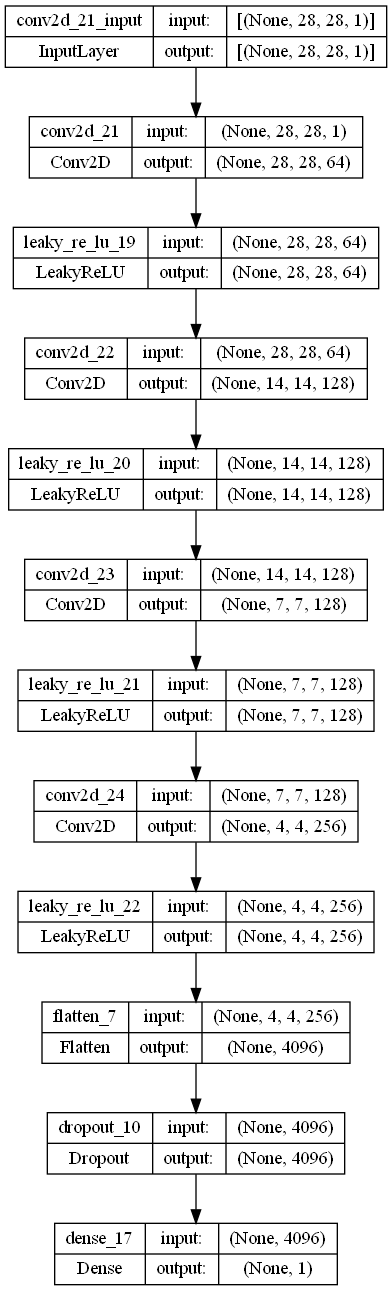

In [99]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(load_dcgan.g_model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)
plot_model(load_dcgan.d_model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

In [58]:
#dcgan = DCGAN(latent_dim=100, dataset=train_data, save_interval=1, save_dir='dcgan_gen_img_v2', clear_dir=True)


In [59]:
#dcgan.train(n_epochs=75, n_batch=128, start_epoch=0, threshold=0.00001)

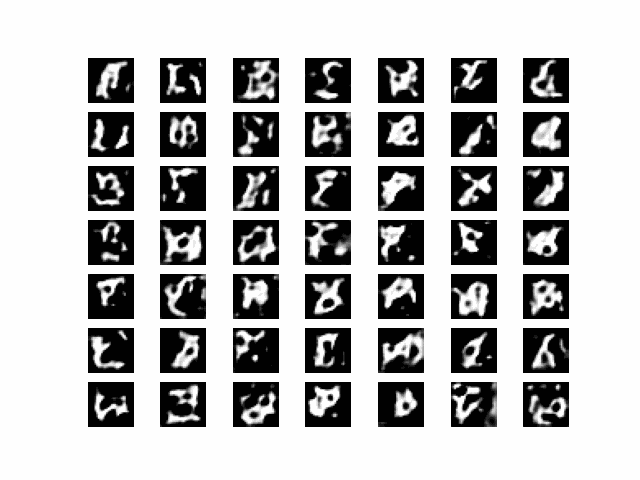

In [60]:
# turn the pictures to a gif
import imageio

images = []

for filename in os.listdir('dcgan_gen_img_v2'):
    if filename.endswith('.png'):
        images.append(imageio.imread(f'dcgan_gen_img_v2/{filename}'))
    
imageio.mimsave('dcgan_gen_img_v2/movie.gif', images, fps=3)

# play the gif and loop it
from IPython.display import Image
Image(filename='dcgan_gen_img_v2/movie.gif', format='png')


In [61]:
# plot the results and a 10 moving average
'''
plt.figure(figsize=(10, 5))
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

axs[0, 0].plot(list(dcgan.logging.keys()), [x['fid'] for x in dcgan.logging.values()])
axs[0, 0].plot(list(dcgan.logging.keys()), pd.Series([x['fid'] for x in dcgan.logging.values()]).rolling(window=10).mean())
axs[0, 0].set_title('FID')

axs[0, 1].plot(list(dcgan.logging.keys()), [x['kl'] for x in dcgan.logging.values()])
axs[0, 1].plot(list(dcgan.logging.keys()), pd.Series([x['kl'] for x in dcgan.logging.values()]).rolling(window=10).mean())
axs[0, 1].set_title('KL')

axs[0, 2].plot(list(dcgan.logging.keys()), [x['jsd'] for x in dcgan.logging.values()])
axs[0, 2].plot(list(dcgan.logging.keys()), pd.Series([x['jsd'] for x in dcgan.logging.values()]).rolling(window=10).mean())
axs[0, 2].set_title('JSD')

axs[1, 0].plot(list(dcgan.logging.keys()), [x['acc_real'] for x in dcgan.logging.values()])
axs[1, 0].plot(list(dcgan.logging.keys()), pd.Series([x['acc_real'] for x in dcgan.logging.values()]).rolling(window=10).mean())
axs[1, 0].set_title('Accuracy Real')

axs[1, 1].plot(list(dcgan.logging.keys()), [x['acc_fake'] for x in dcgan.logging.values()])
axs[1, 1].plot(list(dcgan.logging.keys()), pd.Series([x['acc_fake'] for x in dcgan.logging.values()]).rolling(window=10).mean())
axs[1, 1].set_title('Accuracy Fake')

axs[2, 0].plot(list(dcgan.logging.keys()), [x['g_loss'] for x in dcgan.logging.values()])
axs[2, 0].plot(list(dcgan.logging.keys()), pd.Series([x['g_loss'] for x in dcgan.logging.values()]).rolling(window=10).mean())
axs[2, 0].set_title('G Loss')

axs[2, 1].plot(list(dcgan.logging.keys()), [x['d_loss1'] for x in dcgan.logging.values()])
axs[2, 1].plot(list(dcgan.logging.keys()), pd.Series([x['d_loss1'] for x in dcgan.logging.values()]).rolling(window=10).mean())
axs[2, 1].set_title('D Loss Real')

axs[2, 2].plot(list(dcgan.logging.keys()), [x['d_loss2'] for x in dcgan.logging.values()])
axs[2, 2].plot(list(dcgan.logging.keys()), pd.Series([x['d_loss2'] for x in dcgan.logging.values()]).rolling(window=10).mean())
axs[2, 2].set_title('D Loss Fake')

plt.tight_layout()
plt.show()
'''


"\nplt.figure(figsize=(10, 5))\nfig, axs = plt.subplots(3, 3, figsize=(15, 15))\n\naxs[0, 0].plot(list(dcgan.logging.keys()), [x['fid'] for x in dcgan.logging.values()])\naxs[0, 0].plot(list(dcgan.logging.keys()), pd.Series([x['fid'] for x in dcgan.logging.values()]).rolling(window=10).mean())\naxs[0, 0].set_title('FID')\n\naxs[0, 1].plot(list(dcgan.logging.keys()), [x['kl'] for x in dcgan.logging.values()])\naxs[0, 1].plot(list(dcgan.logging.keys()), pd.Series([x['kl'] for x in dcgan.logging.values()]).rolling(window=10).mean())\naxs[0, 1].set_title('KL')\n\naxs[0, 2].plot(list(dcgan.logging.keys()), [x['jsd'] for x in dcgan.logging.values()])\naxs[0, 2].plot(list(dcgan.logging.keys()), pd.Series([x['jsd'] for x in dcgan.logging.values()]).rolling(window=10).mean())\naxs[0, 2].set_title('JSD')\n\naxs[1, 0].plot(list(dcgan.logging.keys()), [x['acc_real'] for x in dcgan.logging.values()])\naxs[1, 0].plot(list(dcgan.logging.keys()), pd.Series([x['acc_real'] for x in dcgan.logging.values(

### What do these metrics means?



#### FID (Fréchet Inception Distance)
**Explanation:** FID measures the distance between feature vectors calculated for real images and generated images. It uses the Inception network to extract features from both sets of images and then calculates the Fréchet distance between the distributions of these features.

**Better Value:** Lower values indicate that the generated images are closer to the distribution of real images, implying better quality.

#### KL Divergence

**Explanation:** Kullback-Leibler (KL) divergence measures the difference between two probability distributions over the same variable. In the context of GANs, it can be used to measure how much the distribution of generated images differs from the real image distribution.

**Better Value:** Lower values indicate a smaller difference between the distributions, suggesting that the generator is producing images closer to the real image distribution.

#### JSD Divergence

**Explanation:** Jensen-Shannon (JS) divergence is another measure of similarity between two probability distributions. It is symmetric and bounded, unlike KL divergence, making it sometimes preferred for comparing distributions in GANs.

**Better Value:** Similar to KL divergence, lower values of JS divergence indicate that the generated images' distribution is closer to the real images' distribution.

#### Accuracy Real

**Explanation:** This metric measures the discriminator's ability to correctly classify real images as real. It is essentially the accuracy of the discriminator on the real image dataset.

**Better Value:** Higher values indicate better performance, as the discriminator is correctly identifying real images more frequently.

#### Accuracy Fake

**Explanation:** Conversely, this metric measures the discriminator's ability to correctly classify generated (fake) images as fake. It assesses how well the discriminator can distinguish between real and generated images.

**Better Value:** Higher values indicate better performance, showing that the discriminator effectively identifies generated images as not being part of the real dataset.

#### G_loss

**Explanation:** Generator loss (G_loss) measures how well the generator is fooling the discriminator. It is calculated based on the discriminator's ability to distinguish between real and generated images, with the generator aiming to minimize this loss.

**Better Value:** Lower values indicate that the generator is better at producing images that the discriminator cannot easily distinguish from real images.

#### D_loss1

**Explanation:** Discriminator loss 1 (D_loss1) could refer to the loss calculated for real images by the discriminator. It measures how well the discriminator can identify real images as real.

**Better Value:** Lower values indicate better performance, as the discriminator is more accurately identifying real images.

#### D_loss2

**Explanation:** Discriminator loss 2 (D_loss2) likely refers to the loss calculated for fake images by the discriminator. It assesses the discriminator's ability to identify generated images as fake.

**Better Value:** Lower values indicate better performance, showing that the discriminator effectively recognizes generated images as not being real.



### In Theory?

Well in theory, these metrics will help us determine whether our GAN model is generating quality images and that the discriminator is capable of distinguishing between real and fake images. So, the lower the metrics for all of them, except the accuracy, the better our model



### Evaluation of DCGAN
Well, we can see that both models is able to "perform" well, due to how low the losses are for both. However, "perform" is different from generating quality images. We can see from the gif that the images don't particular look like letters, and that is the downfall. We can see this due to the FID, KL, and JSD. It is unable to converge on our real image dataset at all. Lastly, as part of the **requirement**, we need to be able to generate images of any letters. But our generate does not allow us to pass in what letter we want.

## CGAN

This is where CGAN, Conditional Generative Adversial Network, comes in. For our cause, we are making a CDCGAN, a Conditional Deep Convolutional GAN.

The differences is in the "conditional" part. What it does is that the generator has 2 input, 1 for the image and another for the label. The label is then embedding into the image and generates from there. 

![Example of a CGAN](https://se.mathworks.com/help/examples/nnet/win64/TrainConditionalGenerativeAdversarialNetworkCGANExample_02.png)

Here is how the architecture of a CGAN looks like.

So this means in theory, we are able to specify to our model what letter we want the model to generate.

In [62]:
class CDCGAN:
    # Define the standalone discriminator model
    def define_discriminator(self,in_shape=(28,28,1)):
        
        # label input
        n_classes = self.n_classes
        in_label = Input(shape=(1,))
        li = Embedding(n_classes, np.prod(in_shape))(in_label)
        n_nodes = in_shape[0] * in_shape[1]
        li = Dense(n_nodes)(li)
        li = Reshape((in_shape[0], in_shape[1], 1))(li)

        # image input
        in_image = Input(shape=in_shape)

        # concat label as a channel
        merge = Concatenate()([in_image, li])

        model = Conv2D(64, (7,7), padding='same')(merge)
        model = LeakyReLU(alpha=0.2)(model)
        model = Dropout(0.4)(model)
        model = Conv2D(128, (7,7), strides=(2,2), padding='same')(model)
        model = LeakyReLU(alpha=0.2)(model)
        model = Dropout(0.4)(model)
        model = Conv2D(256, (7,7), strides=(2,2), padding='same')(model)
        model = LeakyReLU(alpha=0.2)(model)
        model = Flatten()(model)
        model = Dropout(0.4)(model)
        out_layer = Dense(1, activation='sigmoid')(model)
        model = Model([in_image, in_label], out_layer)
        print(model.summary())
        opt = Adam(learning_rate=0.0002, beta_1=0.5)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        return model

    # Define the standalone generator model
    def define_generator(self):
        latent_dim = self.latent_dim

        # label input'
        in_label = Input(shape=(1,), dtype='int32')
        li = Embedding(self.n_classes, 50)(in_label)
        n_nodes = 7 * 7
        li = Dense(n_nodes)(li)
        li = Reshape((7, 7, 1))(li)

        # image generator input
        in_lat = Input(shape=(latent_dim,))
        n_nodes = 128 * 7 * 7
        gen = Dense(n_nodes)(in_lat)
        gen = LeakyReLU(alpha=0.2)(gen)
        gen = Reshape((7, 7, 128))(gen)

        # merge image gen and label input
        merge = Concatenate()([gen, li])

        model = Conv2DTranspose(128, (7,7), strides=(2,2), padding='same')(merge)
        model = LeakyReLU(alpha=0.2)(model)
        model = Conv2DTranspose(64, (7,7), strides=(2,2), padding='same')(model)
        model = LeakyReLU(alpha=0.2)(model)
        model = Conv2D(1, (3,3), activation='tanh', padding='same')(model)
        model = Model([in_lat, in_label], model)
        print(model.summary())
        return model

    # Define the combined generator and discriminator model, for updating the generator
    def define_gan(self):
        d_model = self.d_model
        g_model = self.g_model
        d_model.trainable = False
        g_noise, g_label = g_model.input
        g_output = g_model.output
        gan_output = d_model([g_output, g_label])
        model = Model([g_noise, g_label], gan_output)
        opt = Adam(learning_rate=0.0002, beta_1=0.5)
        model.compile(loss='binary_crossentropy', optimizer=opt)
        return model
        
    # Select real samples
    def generate_real_samples(self, n_samples):
        dataset = self.dataset
        images, labels = dataset
        ix = randint(0, images.shape[0], n_samples)
        X, labels = images[ix], labels[ix]
        y = np.ones((n_samples, 1))
        return [X, labels], y

    # Generate points in latent space as input for the generator
    def generate_latent_points(self, n_samples):
        latent_dim = self.latent_dim
        n_classes = self.n_classes

        x_input = randn(latent_dim * n_samples)
        z_input = x_input.reshape(n_samples, latent_dim)
        labels = randint(0, n_classes, n_samples)
        return [z_input, labels]

    # Use the generator to generate n fake examples, with class labels
    def generate_fake_samples(self, n_samples, seeded=False):
        g_model = self.g_model
        latent_dim = self.latent_dim
        z_input, labels_input = self.generate_latent_points(n_samples)
        if seeded:
            z_input, labels_input = self.seeded_latent_points
        images = g_model.predict([z_input, labels_input], verbose=0)
        y = np.zeros((n_samples, 1))
        return [images, labels_input], y

    def save_plot(self, examples, epoch, n=7):
        examples = (examples + 1) / 2.0
        for i in range(n * n):
            plt.subplot(n, n, 1 + i)
            plt.axis('off')
            plt.imshow(examples[i], cmap='gray')
        filename = os.path.join(self.save_dir, 'generated_plot_e%03d.png' % (epoch+1))
        plt.savefig(filename)
        plt.close()

    def on_epoch_end(self, epoch, logs=None, g_loss=None, d_loss1=None, d_loss2=None, diff=None):
        #clear output
        display.clear_output(wait=True)
        #print logs
        [X_real, labels_real], y_real = self.generate_real_samples(100)
        _, acc_real = self.d_model.evaluate([X_real, labels_real], verbose=0)
        [x_fake, labels], y_fake = self.generate_fake_samples(100, seeded=True)
        _, acc_fake = self.d_model.evaluate([x_fake, labels], y_fake, verbose=0)
        #print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
        if (epoch + 1) % self.save_interval == 0:
            self.save_plot(x_fake, epoch)
            g_filename = os.path.join(self.save_dir, 'generator_model_%03d.h5' % (epoch+1))
            self.g_model.save(g_filename)
            d_filename = os.path.join(self.save_dir, 'discriminator_model_%03d.h5' % (epoch+1))
            self.d_model.save(d_filename)

        # logging
        # FID
        fid = calculate_fid(vaeNew.encoder, X_real, x_fake)
        x_fake_denorm = denormalize_image(x_fake)
        x_real_denorm = denormalize_image(X_real)
        #print(x_fake_denorm)
        #print(x_real_denorm)
        kl = kl_divergence(x_real_denorm, x_fake_denorm)
        jsd = calculate_jsd(x_real_denorm, x_fake_denorm)
        self.logging[epoch] = {'acc_real': acc_real, 'acc_fake': acc_fake, 'fid': fid, 'kl': kl, 'jsd': jsd, 'g_loss': g_loss, 'd_loss1': d_loss1, 'd_loss2': d_loss2}

        print(f'FID: {fid}, KL: {kl}, JSD: {jsd} | G Loss: {g_loss}, D Loss Real: {d_loss1}, D Loss Fake: {d_loss2}, Diff: {diff} | Epoch {epoch + 1}/{self.epochs}')


    # Train the generator and discriminator
    def train(self,n_epochs=200, n_batch=128, start_epoch=0, threshold=0.5):
        g_model = self.g_model
        d_model = self.d_model
        gan_model = self.gan_model
        dataset = self.dataset
        latent_dim = self.latent_dim
        self.epochs = n_epochs
        bat_per_epo = int(dataset[0].shape[0] / n_batch)
        half_batch = int(n_batch / 2)
        old_g_loss = 0

        for i in range(n_epochs):
            j = 0
            for j in tqdm(range(bat_per_epo), desc=f'Epoch {i + 1}/{n_epochs}', total=bat_per_epo):
                [X_real, labels_real], y_real = self.generate_real_samples(half_batch)
                d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
                [X_fake, labels], y_fake = self.generate_fake_samples(half_batch)
                d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
                [z_input, labels_input] = self.generate_latent_points(n_batch)
                y_gan = np.ones((n_batch, 1))
                g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
                #print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
            #print(g_loss)
            diff = abs(g_loss - old_g_loss)
            if diff < threshold:
                self.on_epoch_end(i, g_loss=g_loss, d_loss1=d_loss1, d_loss2=d_loss2)
                break
            old_g_loss = g_loss

            
            # Call the callback at the end of each epoch
            self.on_epoch_end(i, g_loss=g_loss, d_loss1=d_loss1, d_loss2=d_loss2, diff=diff)
            
    # Init the class
    def __init__(self, latent_dim=100, n_classes=10, dataset=None, save_interval=1, save_dir='generated_images', clear_dir=False):
        self.latent_dim = latent_dim
        self.dataset = dataset
        self.n_classes = n_classes
        self.save_interval = save_interval
        self.save_dir = save_dir
        self.clear_dir = clear_dir
        self.d_model = self.define_discriminator()
        self.g_model = self.define_generator()
        self.gan_model = self.define_gan()
        #self.gan_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
        self.seeded_latent_points = self.generate_latent_points(100)
        self.logging = {}
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        if clear_dir:
            for f in os.listdir(save_dir):
                os.remove(os.path.join(save_dir, f))
    
    def load_models(self, epoch):
        self.g_model = tf.keras.models.load_model(os.path.join(self.save_dir, f'generator_model_{epoch:03d}.h5'))
        self.d_model = tf.keras.models.load_model(os.path.join(self.save_dir, f'discriminator_model_{epoch:03d}.h5'))
        self.gan_model = self.define_gan()

In [63]:
#test= CDCGAN(latent_dim=100, n_classes=26, dataset=[train_data, train_labels], save_interval=1, save_dir='cdcgan_gen_img_v2', clear_dir=False)

In [64]:
'''
train_dataset = (train_data, train_labels)
cdcgan = CDCGAN(latent_dim=100, n_classes=26, dataset=train_dataset, save_interval=1, save_dir='cdcgan_gen_img_v2', clear_dir=True)
cdcgan.train(n_epochs=50, n_batch=64, start_epoch=0, threshold=0.00001)
'''

"\ntrain_dataset = (train_data, train_labels)\ncdcgan = CDCGAN(latent_dim=100, n_classes=26, dataset=train_dataset, save_interval=1, save_dir='cdcgan_gen_img_v2', clear_dir=True)\ncdcgan.train(n_epochs=50, n_batch=64, start_epoch=0, threshold=0.00001)\n"

In [65]:
# turn the pictures to a gif
'''
import imageio

images = []

for filename in os.listdir('cdcgan_gen_img_v2'):
    if filename.endswith('.png'):
        images.append(imageio.imread(f'cdcgan_gen_img_v2/{filename}'))
    
imageio.mimsave('cdcgan_gen_img_v2/movie.gif', images, fps=3)

# play the gif and loop it
from IPython.display import Image
Image(filename='cdcgan_gen_img_v2/movie.gif', format='png')
'''

"\nimport imageio\n\nimages = []\n\nfor filename in os.listdir('cdcgan_gen_img_v2'):\n    if filename.endswith('.png'):\n        images.append(imageio.imread(f'cdcgan_gen_img_v2/{filename}'))\n    \nimageio.mimsave('cdcgan_gen_img_v2/movie.gif', images, fps=3)\n\n# play the gif and loop it\nfrom IPython.display import Image\nImage(filename='cdcgan_gen_img_v2/movie.gif', format='png')\n"

In [66]:
# plot the results and a 10 moving average
'''
plt.figure(figsize=(10, 5))
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

axs[0, 0].plot(list(cdcgan.logging.keys()), [x['fid'] for x in cdcgan.logging.values()])
axs[0, 0].plot(list(cdcgan.logging.keys()), pd.Series([x['fid'] for x in cdcgan.logging.values()]).rolling(window=10).mean())
axs[0, 0].set_title('FID')

axs[0, 1].plot(list(cdcgan.logging.keys()), [x['kl'] for x in cdcgan.logging.values()])
axs[0, 1].plot(list(cdcgan.logging.keys()), pd.Series([x['kl'] for x in cdcgan.logging.values()]).rolling(window=10).mean())
axs[0, 1].set_title('KL')

axs[0, 2].plot(list(cdcgan.logging.keys()), [x['jsd'] for x in cdcgan.logging.values()])
axs[0, 2].plot(list(cdcgan.logging.keys()), pd.Series([x['jsd'] for x in cdcgan.logging.values()]).rolling(window=10).mean())
axs[0, 2].set_title('JSD')

axs[1, 0].plot(list(cdcgan.logging.keys()), [x['acc_real'] for x in cdcgan.logging.values()])
axs[1, 0].plot(list(cdcgan.logging.keys()), pd.Series([x['acc_real'] for x in cdcgan.logging.values()]).rolling(window=10).mean())
axs[1, 0].set_title('Accuracy Real')

axs[1, 1].plot(list(cdcgan.logging.keys()), [x['acc_fake'] for x in cdcgan.logging.values()])
axs[1, 1].plot(list(cdcgan.logging.keys()), pd.Series([x['acc_fake'] for x in cdcgan.logging.values()]).rolling(window=10).mean())
axs[1, 1].set_title('Accuracy Fake')

axs[2, 0].plot(list(cdcgan.logging.keys()), [x['g_loss'] for x in cdcgan.logging.values()])
axs[2, 0].plot(list(cdcgan.logging.keys()), pd.Series([x['g_loss'] for x in cdcgan.logging.values()]).rolling(window=10).mean())
axs[2, 0].set_title('G Loss')

axs[2, 1].plot(list(cdcgan.logging.keys()), [x['d_loss1'] for x in cdcgan.logging.values()])
axs[2, 1].plot(list(cdcgan.logging.keys()), pd.Series([x['d_loss1'] for x in cdcgan.logging.values()]).rolling(window=10).mean())
axs[2, 1].set_title('D Loss Real')

axs[2, 2].plot(list(cdcgan.logging.keys()), [x['d_loss2'] for x in cdcgan.logging.values()])
axs[2, 2].plot(list(cdcgan.logging.keys()), pd.Series([x['d_loss2'] for x in cdcgan.logging.values()]).rolling(window=10).mean())
axs[2, 2].set_title('D Loss Fake')

plt.tight_layout()
plt.show()
'''

"\nplt.figure(figsize=(10, 5))\nfig, axs = plt.subplots(3, 3, figsize=(15, 15))\n\naxs[0, 0].plot(list(cdcgan.logging.keys()), [x['fid'] for x in cdcgan.logging.values()])\naxs[0, 0].plot(list(cdcgan.logging.keys()), pd.Series([x['fid'] for x in cdcgan.logging.values()]).rolling(window=10).mean())\naxs[0, 0].set_title('FID')\n\naxs[0, 1].plot(list(cdcgan.logging.keys()), [x['kl'] for x in cdcgan.logging.values()])\naxs[0, 1].plot(list(cdcgan.logging.keys()), pd.Series([x['kl'] for x in cdcgan.logging.values()]).rolling(window=10).mean())\naxs[0, 1].set_title('KL')\n\naxs[0, 2].plot(list(cdcgan.logging.keys()), [x['jsd'] for x in cdcgan.logging.values()])\naxs[0, 2].plot(list(cdcgan.logging.keys()), pd.Series([x['jsd'] for x in cdcgan.logging.values()]).rolling(window=10).mean())\naxs[0, 2].set_title('JSD')\n\naxs[1, 0].plot(list(cdcgan.logging.keys()), [x['acc_real'] for x in cdcgan.logging.values()])\naxs[1, 0].plot(list(cdcgan.logging.keys()), pd.Series([x['acc_real'] for x in cdcgan

### Evaluation of DCGAN
From the losses, we can see the discriminator improving. However for the generator, the losses seems to have increase. It can be attributed to 2 reason, mainly the generator diverges or the training has been completed. The first means that the geneator struggles to fool the discriminator effectively. For the later, it means that the generator has been fully trained and cannot be improved.

For the FID, KL and JSD, we can see that it maintains a certain levels. Thus suggest that the quality has remained the same. Unlike the DCGAN where the quality drops over training.

## ACGAN
ACGAN referes to Auxiliary Classifier GAN (ACGAN). It is similar to a CGAN where the generator has a label input to controll the image generated. However, the key differentiaing feature is that the discriminator has an additional role for a ACGAN - it acts as a classifier by predicting the class labels of the generated images alongside distinguishing between real and fake images.

In [67]:
class ACGAN:
    def __init__(self, dataset, latent_dim=100, img_shape=(28, 28, 1), num_classes=26, save_interval=1, save_dir='acgan_gen_img', clear_dir=False):
        self.latent_dim = latent_dim
        self.img_shape = img_shape
        self.num_classes = num_classes
        self.save_interval = save_interval
        self.save_dir = save_dir
        self.dataset = dataset
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        if clear_dir:
            for f in os.listdir(save_dir):
                os.remove(os.path.join(save_dir, f))

        self.discriminator = self.build_discriminator(img_shape=self.img_shape, num_classes=self.num_classes)
        self.generator = self.build_generator(num_classes=self.num_classes)
        self.combined = self.build_combined()
        self.seeded_latent_points = self.generate_latent_points(100)
        self.g_loss_old = 0
        self.logs = {}

    def build_generator(self, num_classes=10):
        latent_dim = self.latent_dim

        # Noise input
        noise_input = Input(shape=(latent_dim,))
        n_nodes = 128 * 7 * 7
        gen = Dense(n_nodes)(noise_input)
        gen = LeakyReLU(alpha=0.2)(gen)
        gen = Reshape((7, 7, 128))(gen)
        
        # Label input
        label_input = Input(shape=(num_classes,))
        # Embedding for categorical input
        label_embedding = (Embedding(num_classes, 50)(label_input))
        n_nodes = 7 * 7
        label_embedding = Dense(n_nodes)(label_embedding)
        label_embedding = Reshape((7, 7, 26))(label_embedding)
        # Multiplied embedding for categorical input with noise vector
        x = Concatenate()([gen, label_embedding])

        # Up-sampling layers
        x = BatchNormalization(momentum=0.8)(x)
        x = Activation("relu")(x)
        x = Conv2DTranspose(128, kernel_size=3, strides=2, padding="same")(x)

        x = BatchNormalization(momentum=0.8)(x)
        x = Activation("relu")(x)
        x = Conv2DTranspose(64, kernel_size=3, strides=2, padding="same")(x)

        # Output layer 28x28x1
        img_output = Conv2DTranspose(1, kernel_size=7, activation='tanh', padding='same')(x)

        # Conditional model
        cond_model = Model(inputs=[noise_input, label_input], outputs=img_output)
        cond_model.summary()

        return cond_model


    def build_discriminator(self, img_shape=(28,28,1), num_classes=2):

        model = Sequential()

        # Label input
        in_label = Input(shape=(num_classes,))
        # Embedding for categorical input
        li = Embedding(num_classes, np.prod(img_shape))(in_label)
        li = Reshape((img_shape[0], img_shape[1], num_classes))(li)

        # Image input
        in_image = Input(shape=img_shape)

        # Concatenate label embedding and image to produce input
        merged_input = Concatenate()([in_image, li])

        # Down-sampling layers
        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))

        # Output layers
        image = Conv2D(1, kernel_size=3, padding="same")(merged_input)
        validity = Activation("sigmoid")(image)

        label = Flatten()(merged_input)
        label = Dense(num_classes, activation="softmax")(label)

        # Discriminator model
        d_model = Model(inputs=[in_image, in_label], outputs=[validity, label])

        d_model.compile(loss=['binary_crossentropy', 'categorical_crossentropy'], optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
        return d_model

    def build_combined(self):
        # Combine models
        z = Input(shape=(self.latent_dim,))
        label_input = Input(shape=(self.num_classes,), dtype='int32')
        image = self.generator([z, label_input])

        self.discriminator.trainable = False

        valid, _ = self.discriminator([image, label_input])
        combined = Model([z, label_input], valid)
        combined.compile(loss=['binary_crossentropy', 'categorical_crossentropy'], optimizer=Adam(0.0002, 0.5))
        return combined

    def train(self, epochs=50, batch_size=128):
        dataset = self.dataset
        self.epochs = epochs
        X_train, y_train = dataset

        # Adversarial ground truths
        valid = np.ones((batch_size, 28, 28, 1))
        fake = np.zeros((batch_size, 28, 28, 1))

        
        for epoch in range(epochs):
            # ---------------------
            #  Train Discriminator
            # ---------------------
            
            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs, labels = X_train[idx], y_train[idx]
            print(labels.shape)
            
            # Sample noise and generate a batch of new images
            z = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict([z, labels])
            
            # Train the discriminator (real classified as ones and fakes as zeros)
            d_loss_real = self.discriminator.train_on_batch([imgs, labels], [valid, labels])
            d_loss_fake = self.discriminator.train_on_batch([gen_imgs, labels], [fake, labels])
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # ---------------------
            #  Train Generator
            # ---------------------
            
            # Train the generator (wants discriminator to mistake images as real)
            sampled_labels = np.random.randint(0, self.num_classes, batch_size).reshape(-1, 1)
            sampled_labels = to_categorical(sampled_labels, num_classes=self.num_classes)
            
            z = np.random.normal(0, 1, (batch_size, self.latent_dim))
            
            g_loss = self.combined.train_on_batch([z, sampled_labels], valid)
            
            self.on_epoch_end(epoch)
                
        print("Training completed.")

    def generate_real_samples(self, n_samples):
        dataset = self.dataset
        images, labels = dataset
        ix = randint(0, images.shape[0], n_samples)
        X, labels = images[ix], labels[ix]
        y = np.ones((n_samples, 28, 28, 1))
        return [X, labels], y
    
    def generate_fake_samples(self, n_samples, seeded=False):
        g_model = self.generator
        latent_dim = self.latent_dim
        z_input, labels_input = self.generate_latent_points(n_samples)
        if seeded:
            z_input, labels_input = self.seeded_latent_points
        #print(z_input.shape)
        #print(labels_input.shape)
        images = g_model.predict([z_input, labels_input], verbose=0)
        y = np.zeros((n_samples, 28, 28, 1))
        return [images, labels_input], y

    def generate_latent_points(self, n_samples):
        latent_dim = self.latent_dim
        n_classes = self.num_classes

        x_input = randn(latent_dim * n_samples)
        z_input = x_input.reshape(n_samples, latent_dim)
        labels = randint(0, n_classes, n_samples)
        labels = to_categorical(labels, num_classes=n_classes)
        return [z_input, labels]

    def save_plot(self, examples, epoch, n=7):
        examples = (examples + 1) / 2.0
        for i in range(n * n):
            plt.subplot(n, n, 1 + i)
            plt.axis('off')
            plt.imshow(examples[i], cmap='gray')
        filename = os.path.join(self.save_dir, 'generated_plot_e%03d.png' % (epoch+1))
        plt.savefig(filename)
        plt.close()
    
    def on_epoch_end(self, epoch, logs=None):
        #clear output
        display.clear_output(wait=True)
        #print logs
        [X_real, labels_real], y_real = self.generate_real_samples(100)
        d_loss_real = self.discriminator.evaluate([X_real, labels_real], [y_real, labels_real], verbose=0)
        acc_real = d_loss_real[2]
        d_loss_real = d_loss_real[0]

        [x_fake, labels], y_fake = self.generate_fake_samples(100, seeded=True)
        d_loss_fake = self.discriminator.evaluate([x_fake, labels], [y_fake, labels], verbose=0)
        acc_fake = d_loss_fake[2]
        d_loss_fake = d_loss_fake[0]

        z = self.seeded_latent_points[0]
        labels = self.seeded_latent_points[1]

        g_loss = self.combined.evaluate([z, labels], y_fake, verbose=0)
        g_loss = g_loss
        #print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
        if (epoch + 1) % self.save_interval == 0:
            self.save_plot(x_fake, epoch)
            g_filename = os.path.join(self.save_dir, 'generator_model_%03d.h5' % (epoch+1))
            self.generator.save(g_filename)
            d_filename = os.path.join(self.save_dir, 'discriminator_model_%03d.h5' % (epoch+1))
            self.discriminator.save(d_filename)

        # logging
        diff = abs(g_loss - self.g_loss_old)
        self.g_loss_old = g_loss
        # FID
        fid = calculate_fid(vaeNew.encoder, X_real, x_fake)
        x_fake_denorm = denormalize_image(x_fake)
        x_real_denorm = denormalize_image(X_real)
        kl = kl_divergence(x_real_denorm, x_fake_denorm)
        jsd = calculate_jsd(x_real_denorm, x_fake_denorm)
        self.logs[epoch] = {'acc_real': acc_real, 'acc_fake': acc_fake, 'fid': fid, 'kl': kl, 'jsd': jsd, 'g_loss': g_loss, 'd_loss1': d_loss_real, 'd_loss2': d_loss_fake}

        print(f'FID: {fid}, KL: {kl}, JSD: {jsd} | G Loss: {g_loss}, D Loss Real: {d_loss_real}, D Loss Fake: {d_loss_fake}, Diff: {diff} | Epoch {epoch + 1}/{self.epochs}')

In [68]:
#turn the labels from 1-26 to 0-25
train_labels_0 = train_labels - 1
print(train_labels_0.value_counts())

0
24    3453
10    3438
4     3437
23    3437
19    3436
16    3435
15    3430
8     3428
25    3427
7     3424
22    3423
21    3422
17    3419
20    3419
2     3419
11    3415
14    3408
9     3402
12    3402
3     3398
1     3396
0     3396
5     3394
18    3392
6     3385
13    3365
Name: count, dtype: int64


In [69]:

# train_labels_cat = to_categorical(train_labels_0, num_classes=26)
# train_dataset = (train_data, train_labels_cat)

# acgan = ACGAN(dataset=train_dataset, latent_dim=100, img_shape=(28, 28, 1), num_classes=26, save_interval=1, save_dir='acgan_gen_img', clear_dir=True)
# acgan.train(epochs=50, batch_size=1024)

# Hyper Tunning CGAN

In [ ]:
import tensorflow as tf
import optuna
import pandas as pd
import numpy as np
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate

from tqdm import tqdm

## Metrics
That's right folks, I am gonna do Attempt 2 with inception score.

## Loading functions


In [ ]:
def load_real_samples():
	# load dataset
	df = pd.read_csv('emnist-letters-train.csv', header=None)
	df = df[df[0] != -1]
	trainy = df[0]
	trainX = df.drop(0, axis=1)

	# augement x
	augmented_data = []
	for i in trainX.index:
		pixels = trainX.loc[i].values
		image = np.array(pixels).reshape(28,28)
		rotated_image = np.rot90(image, k=-1)
		flipped_horizontal = np.fliplr(rotated_image)
		augmented_data.append(flipped_horizontal)
	
	trainX = np.array(augmented_data)
	trainX = trainX.reshape(trainX.shape[0], 28, 28, 1)

	# convert from ints to floats
	X = trainX.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5

	# reset index
	trainy = trainy.reset_index(drop=True)

	return [X, trainy]


In [ ]:
# Set up local functions
def generate_latent_points(latent_dim, n_samples, n_classes=26):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input], verbose=0)
    # create class labels
    y = zeros((n_samples, 1))
    return [images, labels_input], y

def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return [X, labels], y

def define_discriminator(in_shape=(28,28,1), n_classes=26, trial=None):
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # scale up to image dimensions with linear activation
    n_nodes = in_shape[0] * in_shape[1]
    li = Dense(n_nodes)(li)
    # reshape to additional channel
    li = Reshape((in_shape[0], in_shape[1], 1))(li)
    # image input
    in_image = Input(shape=in_shape)
    # concat label as a channel
    merge = Concatenate()([in_image, li])
    # downsample
    d_conv_layers = trial.suggest_int('d_conv_layers', 1, 3)
    for i in range(d_conv_layers):
        d_num_filters = trial.suggest_int('d_num_filters_l{}'.format(i), 32, 128)
        merge = Conv2D(d_num_filters, (3,3), strides=(2,2), padding='same')(merge)
        merge = LeakyReLU(alpha=0.2)(merge)

    # flatten feature maps
    fe = Flatten()(merge)
    # dropout
    fe = Dropout(0.4)(fe)
    # output
    out_layer = Dense(1, activation='sigmoid')(fe)
    # define model
    model = Model([in_image, in_label], out_layer)

    # compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    #print(model.summary())
    return model

def define_generator(latent_dim, n_classes=26, trial=None):
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # linear multiplication
    n_nodes = 7 * 7
    li = Dense(n_nodes)(li)
    # reshape to additional channel
    li = Reshape((7, 7, 1))(li)
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((7, 7, 128))(gen)
    # merge image gen and label input
    merge = Concatenate()([gen, li])
    
    # upsample to 14x14
    g_convT_layers = trial.suggest_int('g_convT_layers', 2, 4)

    current_size = 7
    target_size = 28

    for i in range(g_convT_layers):
        # Calculate the stride and kernel size based on remaining upsampling needed
        stride = 2 if current_size * 2 <= target_size else 1
        kernel_size = 4 if current_size * 2 <= target_size else 3  # Adjust based on stride
        
        g_num_filters = trial.suggest_int('g_num_filters_l{}'.format(i), 64, 128) if trial else 128  # Default value if trial is None
        merge = Conv2DTranspose(g_num_filters, (kernel_size,kernel_size), strides=(stride,stride), padding='same')(merge)
        merge = LeakyReLU(alpha=0.2)(merge)

        current_size *= stride

    # output
    out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(merge)

    # define model
    model = Model([in_lat, in_label], out_layer)
    return model

def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # get noise and label inputs from generator model
    gen_noise, gen_label = g_model.input
    # get image output from the generator model
    gen_output = g_model.output

    # print shapes
    #print(gen_noise.shape)
    #print(gen_label.shape)
    #print(gen_output.shape)

    # connect image output and label input from generator as inputs to discriminator
    gan_output = d_model([gen_output, gen_label])
    # define gan model as taking noise and label and outputting a classification
    model = Model([gen_noise, gen_label], gan_output)
    # compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

def js_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)

def learn(g_model, d_model, gan_model, dataset, latent_dim, n_batch=128, curr_epoch=0, max_epochs=100):
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(1):
        # enumerate batches over the training set
        for j in tqdm(range(bat_per_epo), desc="Epoch {}/{}".format(curr_epoch, max_epochs)):
            # get randomly selected 'real' samples
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            # generate 'fake' examples
            [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            # prepare points in latent space as input for the generator
            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
            # summarize loss on this batch
            #print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))

def evaluate(g_model, d_model, dataset, latent_dim, n_batch=128):
    # calculate KL and JSD values
    [X_real, labels_real], _ = generate_real_samples(dataset, n_batch)
    [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
    [X_fake, _], _ = generate_fake_samples(g_model, latent_dim, n_batch)
    # use the discriminator to classify real and fake samples
    d_real = d_model.predict([X_real, labels_real], verbose=0)
    d_fake = d_model.predict([X_fake, labels_input], verbose=0)

    # calculate kl and js divergence
    kl_score = kl_divergence(d_real, d_fake)
    js_score = js_divergence(d_real, d_fake)

    print('KL divergence: %.3f' % kl_score)
    print('JS divergence: %.3f' % js_score)

    return kl_score, js_score

In [ ]:
import numpy as np

def objective(trial):
    
            
    (trainX, trainy) = load_real_samples()

    # size of the latent space
    latent_dim = 100

    # create the discriminator
    d_model = define_discriminator(trial=trial)
    # create the generator
    g_model = define_generator(latent_dim, trial=trial)
    # create the gan
    gan_model = define_gan(g_model, d_model)

    # train model
    with tf.device('/device:GPU:0'):
        epochs = trial.suggest_int('epochs', 10, 50)
        
        # print trial
        print(f"Trial {trial.number} with parameters {trial.params}")

        for _ in range(epochs):
            learn(g_model, d_model, gan_model, [trainX, trainy], latent_dim, curr_epoch=_, max_epochs=epochs)

        # evaluate model
        kl_score, js_score = evaluate(g_model, d_model, [trainX, trainy], latent_dim)
        return kl_score

    

In [ ]:
study = optuna.create_study(direction='minimize', study_name='emnist_letters_gan', storage='sqlite:///emnist_letters_gan10.db', load_if_exists=True)

#study.optimize(objective, n_trials=1)

#save to csv
df = study.trials_dataframe()
df.to_csv('emnist_letters_gan10.csv')

print("Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# generating images


In [ ]:

finalCgan = CDCGAN(latent_dim=100, n_classes=26, dataset=(train_data, train_labels), save_interval=1, save_dir='cdcgan_gen_img_v2', clear_dir=False)
finalCgan.load_models(50)


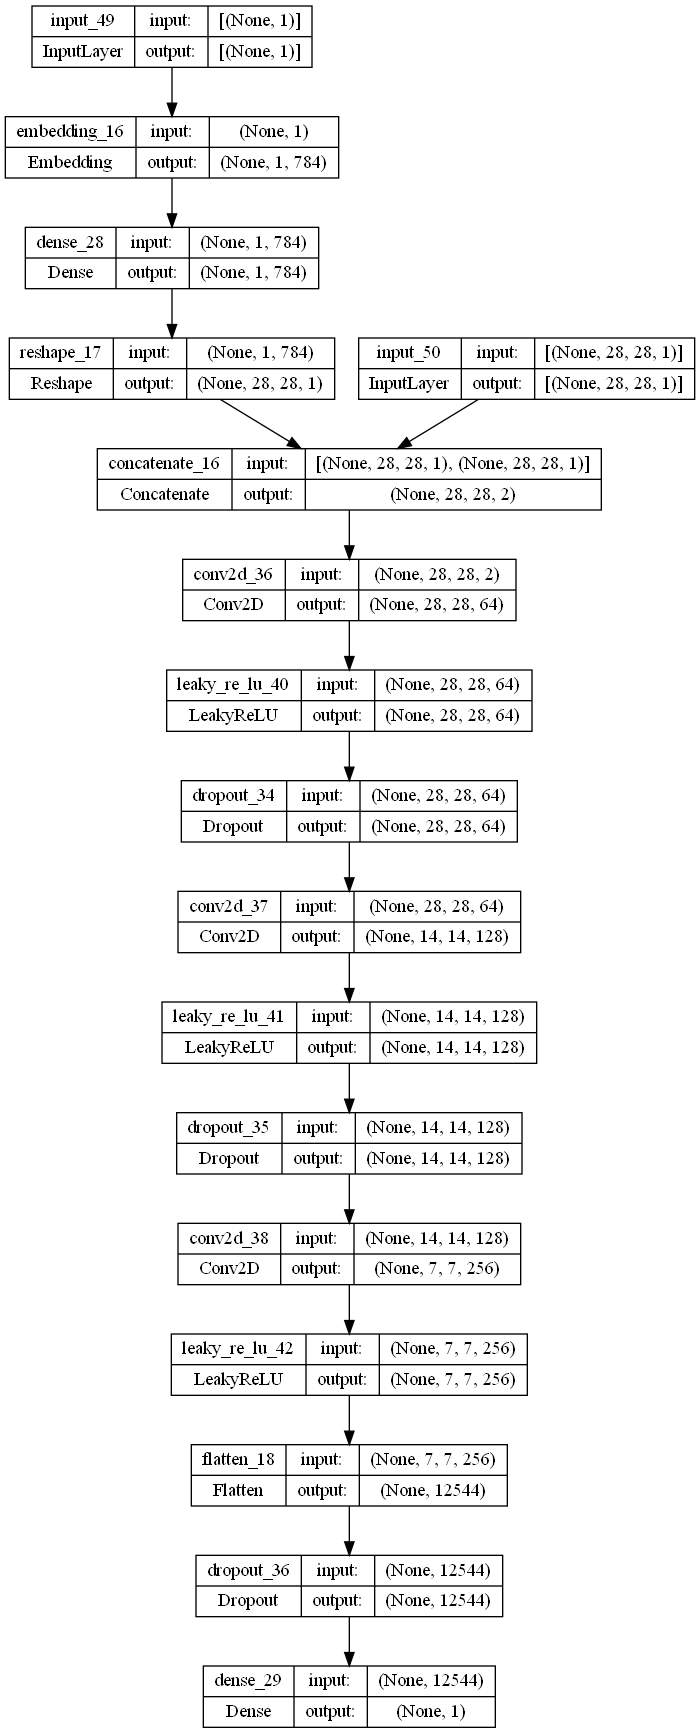

In [100]:
# plot model
plot_model(finalCgan.g_model, to_file='cgan_generator_plot.png', show_shapes=True, show_layer_names=True)
plot_model(finalCgan.d_model, to_file='cgan_discriminator_plot.png', show_shapes=True, show_layer_names=True)

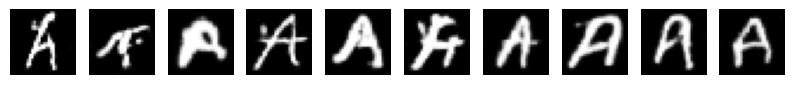

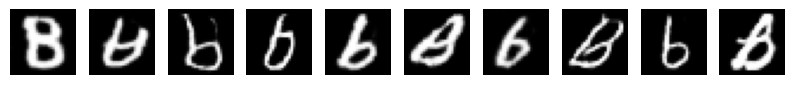

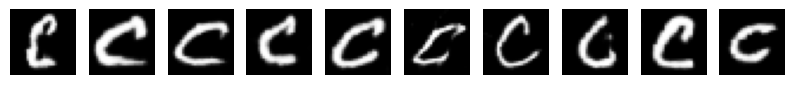

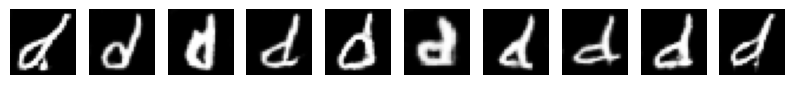

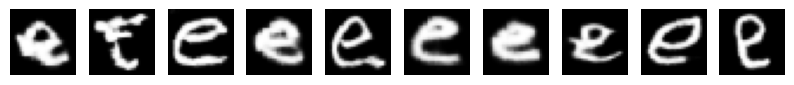

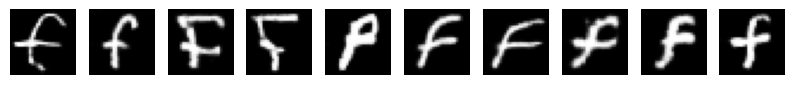

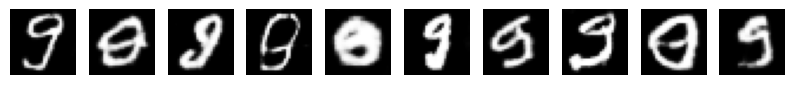

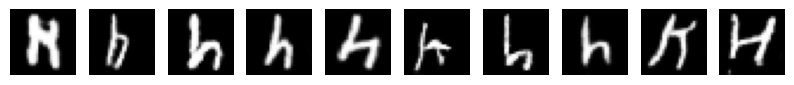

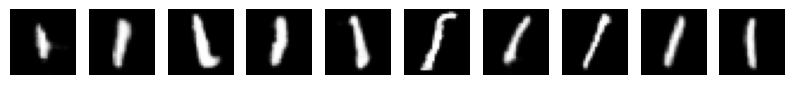

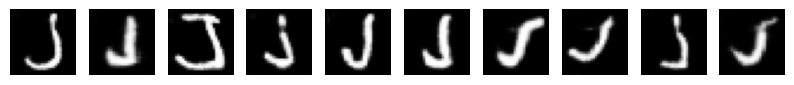

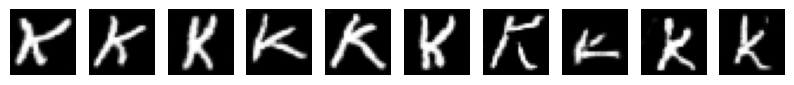

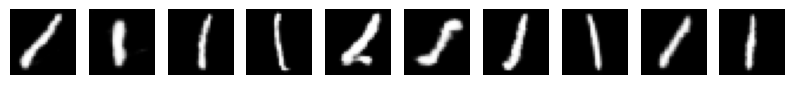

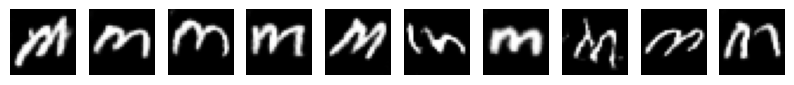

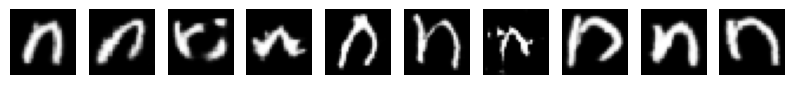

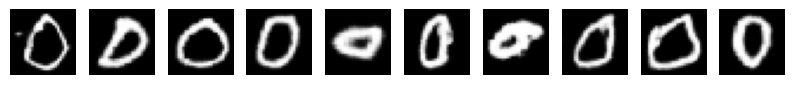

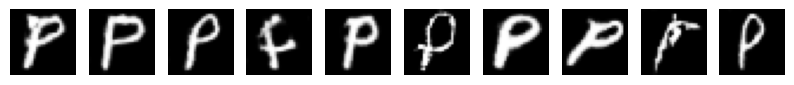

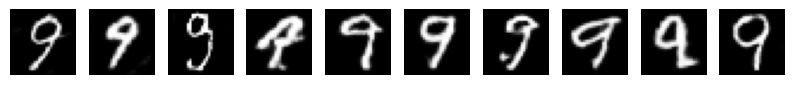

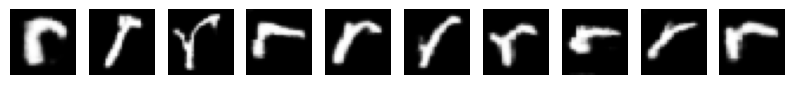

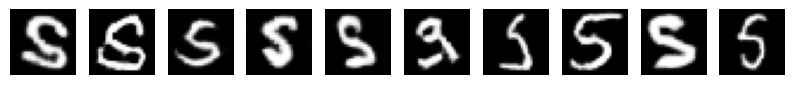

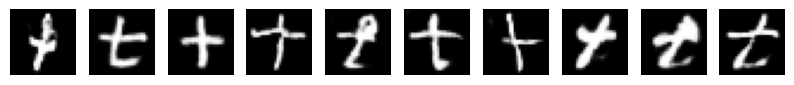

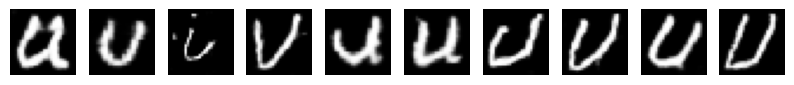

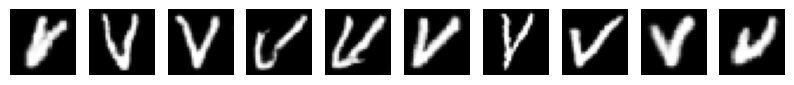

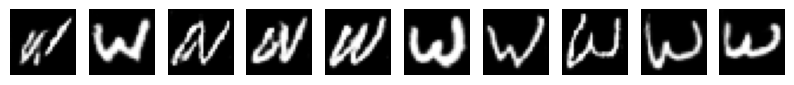

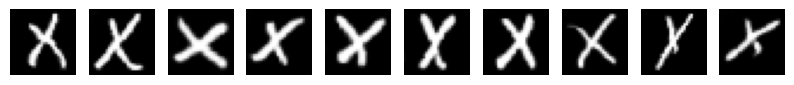

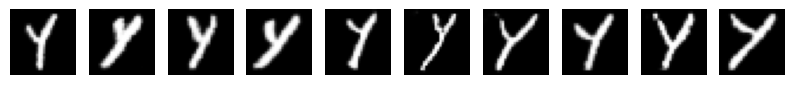

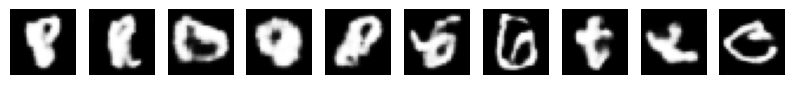

In [91]:
# generate 260 images, 10 for each class
save_dir = 'final_images'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for i in range(26):
    letter_dir = os.path.join(save_dir, f'{chr(i+65)}')
    if not os.path.exists(letter_dir):
        os.makedirs(letter_dir)
    
    images_generated = []

    for j in range(10):
        noise = np.random.normal(0, 1, (1, 100))
        label = np.array([i+1])
        img = finalCgan.g_model.predict([noise, label], verbose=0)
        # save the image to the directory
        img = img.reshape(28, 28)
        plt.imsave(os.path.join(letter_dir, f'{chr(i+65)}_{j}.png'), img, cmap='gray')

        images_generated.append(img)


    # show the plot of the generated images
    plt.figure(figsize=(10,10))
    for k in range(10):
        plt.subplot(1, 10, k+1)
        plt.axis('off')
        plt.imshow(images_generated[k], cmap='gray')
    plt.show()
